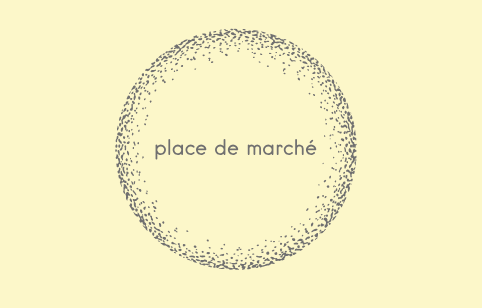

**This notebook will not run in a Windows environment beyond paragraph 2.3 - use Google Colab from paragraph 3 onwards.**

# Import packages & librairies

In [9]:
# utilities
import sys
import datetime
from datetime import datetime
import random
import time
import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere
import os
os.environ["TF_KERAS"]='1'
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["OMP_NUM_THREADS"] = '1'  # needed to avoid memory leak warning with K-Means in Windows environment
from os import listdir
from glob import glob

# data cleaning & processing
import pandas as pd
import numpy as np
from sklearn import preprocessing

# dataviz
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter

# image processing
import cv2
from PIL import Image

# custom user functions
from functions import *

# modelisation
from sklearn import cluster, metrics, manifold, decomposition
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

# set dataframe display options
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x) # Suppress scientific notation and show only 4 decimals
# pd.set_option('display.float_format', lambda x: '%.f' % x) # Suppress scientific notation and show only integer part

# silence warnings after checking
import warnings
# pd.set_option('future.no_silent_downcasting', False) # introduced in pandas 2.0.0., this notebook uses 1.4.4
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning) # introduced in pandas 2.0.0., this notebook uses 1.4.4
# from PIL import ImageDecompressionBombWarning
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# extract colors from logo for ppt slideshow
# banana = findColor('banana.png')
# print("banana hex :", banana)
banana = '#fcf7c9'

viridis_sample = ['#481567FF','#453781FF','#39568CFF','#2D708EFF','#238A8DFF','#20A387FF','#3CBB75FF', '#73D055FF','#B8DE29FF']

viridis_palette = ['#440154', '#481e70', '#443982', '#3a528b', '#30678d', '#287b8e', '#20908c', '#20a485', '#35b778', '#5ec961',
                   '#90d643', '#c7e01f', '#fde724']

sunset_palette = ["#FFEB3B", "#FFDA44", "#FFC107", "#FFB300", "#FFA000", "#FF8F00", "#FF6F00", "#FF5722", "#FF3D00", "#FF2D00",
                  "#E53935", "#D32F2F", "#C62828", "#B71C1C", "#FF5252", "#FF1744", "#FF4081", "#F50057", "#D5006D", "#C51162"]

palette = ['#440154', '#481e70', '#443982', '#3a528b', '#30678d', '#287b8e', '#20908c', '#20a485', '#35b778', '#5ec961',
           '#90d643', '#c7e01f', '#fde724', "#FFEB3B", "#FFDA44", "#FFC107", "#FFB300", "#FFA000", "#FF8F00", "#FF6F00",
           "#FF5722", "#FF3D00", "#FF2D00", "#E53935", "#D32F2F", "#C62828", "#B71C1C", "#FF5252", "#FF1744", "#FF4081",
           "#F50057", "#D5006D", "#C51162"]

In [2]:
print(np.__version__, '\n')
print(tf.__file__, '\n')
print(tf.__version__, '\n')
print(hasattr(tf, 'keras'), '\n')
print(type(tf), '\n')
print(tf.__spec__, '\n')
print(dir(tf.keras))  # should list keras submodules

2.0.2 

/usr/local/lib/python3.11/dist-packages/tensorflow/__init__.py 

2.18.0 

True 

<class 'module'> 

ModuleSpec(name='tensorflow', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7aa30587bdd0>, origin='/usr/local/lib/python3.11/dist-packages/tensorflow/__init__.py', submodule_search_locations=['/usr/local/lib/python3.11/dist-packages/tensorflow', '/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2']) 

['DTypePolicy', 'FloatDTypePolicy', 'Function', 'Initializer', 'Input', 'InputSpec', 'KerasTensor', 'Layer', 'Loss', 'Metric', 'Model', 'Operation', 'Optimizer', 'Quantizer', 'Regularizer', 'Sequential', 'StatelessScope', 'SymbolicScope', 'Variable', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'activations', 'applications', 'backend', 'callbacks', 'config', 'constraints', 'datasets', 'device', 'distribution', 'dtype_policies', 'export', 'initializers', 'layers', 'legacy

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow detected {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("TensorFlow did NOT detect any GPUs.")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

TensorFlow detected 1 GPU(s):
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Num GPUs Available:  1
True


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 20 12:56:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
# initialise random state for all models and transformers
rs_list = [8, 13, 42]
rs = rs_list[random.randrange(len(rs_list))]
print("Random state =", rs)

Random state = 13


# 1 - Import & explore data

## 1.1 - Import photos

In [9]:
path = "C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images"
# path = '/content/drive/My Drive/Colab Notebooks/OCDS_P6/flipkart_images'
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [ ]:
save_path = "C:/Users/celin/DS Projets Python/OCDS-repos-all/OCDS-P6"
# save_path = '/content/drive/My Drive/Colab Notebooks/OCDS_P6'

## 1.2 - Import labels

In [ ]:
data = pd.read_parquet('products_trim_final.parquet.gzip')
# data = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/OCDS_P6/products_trim_final.parquet.gzip')
print(data.shape)
# data.head(1)

(1050, 19)


In [ ]:
photo_data = data[['image', 'product_category', 'real_clusters']]
photo_data = photo_data.rename(columns={'image' : 'image_path'})
print(photo_data.shape)
photo_data.head()

(1050, 3)


image_path  product_category  real_clusters
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing               4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care               0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care               0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing               4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing               4

In [ ]:
photo_data['product_category'].value_counts()

product_category
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

In [ ]:
photo_categories = pd.read_csv('category_mapping.csv', index_col=0)
# photo_categories = pd.read_csv('/content/drive/My Drive/Colab Notebooks/OCDS_P6/category_mapping.csv', index_col=0)
photo_categories

category_numeric
product_category                             
Baby Care                                   0
Beauty and Personal Care                    1
Computers                                   2
Home Decor & Festive Needs                  3
Home Furnishing                             4
Kitchen & Dining                            5
Watches                                     6

## 1.3 - Create results storage dataframe

In [10]:
CNN_results = pd.DataFrame(columns=['Extractor', 'Fit time', 'ARI'])
CNN_results['Extractor'] = ['SIFT-BA', 'SIFT-DI', 'ORB-BA', 'ORB-IP', 'VGG-16', 'VGG-19', 'ResNet50', 'Xception', 'InceptionV3']
CNN_results

Extractor Fit time  ARI
0      SIFT-BA      NaN  NaN
1      SIFT-DI      NaN  NaN
2       ORB-BA      NaN  NaN
3       ORB-IP      NaN  NaN
4       VGG-16      NaN  NaN
5       VGG-19      NaN  NaN
6     ResNet50      NaN  NaN
7     Xception      NaN  NaN
8  InceptionV3      NaN  NaN

## 1.4 - Define functions

### 1.4.1 - Features extraction

In [11]:
def extract_features_from_list(model, preprocess_func, list_photos, path, target_size=(299, 299)):
    features = []
    start_time = time.time()
    for i, photo in enumerate(list_photos):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(list_photos)}")
        img_path = path + '/' + photo  # full path to image
        image = load_img(img_path, target_size=target_size)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_func(image)
        feat = model.predict(image, verbose=0)
        features.append(feat[0])
    duration = time.time() - start_time
    print(f"Features creation time: {duration:.2f} secs")
    return np.array(features)

In [12]:
def extract_sift_descriptors(list_photos, path, sift):
    sift_keypoints = []

    for image_num, filename in enumerate(list_photos):
        if image_num % 50 == 0:
           print(f'progress : {image_num / len(list_photos) * 100:.2f} %')

        image_path = os.path.join(path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale

        if image is None:
            print(f"Could not load image: {image_path}")
            sift_keypoints.append(None)  # Keep alignment with input list
            continue

        # Histogram equalization
        equalized = cv2.equalizeHist(image)

        # Detect SIFT keypoints and descriptors
        kp, des = sift.detectAndCompute(equalized, None)

        sift_keypoints.append(des)

    return sift_keypoints

In [13]:
def sift_on_downsampled(image, downscale_factor=0.5):
    """Apply SIFT on a downsampled image for faster processing."""
    sift = cv2.SIFT_create()
    # Resize image
    resized_image = cv2.resize(image, None, fx=downscale_factor, fy=downscale_factor)
    # Detect and compute keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(resized_image, None)

    # Scale keypoint coordinates back to original image size
    if keypoints is not None:
        for k in keypoints:
            k.pt = (k.pt[0] / downscale_factor, k.pt[1] / downscale_factor)

    return keypoints, descriptors

In [14]:
def list_pix(name) :
    list_image_name = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]==name]
    return list_image_name

### 1.4.2 - Graphing

In [15]:
def plot_pca_scree(explained_variance_ratio, cumulative_variance, components,
                   num_components_99, num_component_threshold,
                   num_component_kaiser, cumulative_variance_kaiser,
                   max_ticks=10,
                   save_path=None):

    sns.set(rc={'figure.figsize': (7, 4), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})

    step = max(1, len(components) // max_ticks)
    xticks_to_show = components[::step]

    individual_color = 'cornflowerblue'
    cumulative_color = banana
    line_99_color = 'limegreen'
    line_kaiser_color = 'fuchsia'

    plt.plot(components, explained_variance_ratio * 100,
             linewidth=2, color=individual_color, label='Individual Explained Variance')
    plt.plot(components, cumulative_variance * 100,
             linewidth=2, color=cumulative_color, label='Cumulative Explained Variance')

    plt.axhline(y=99, color=line_99_color, linestyle='--',
                label='99% Variance Threshold', linewidth=0.5)

    plt.axhline(y=cumulative_variance_kaiser, color=line_kaiser_color, linestyle='--',
                label=f'Kaiser Variance {cumulative_variance_kaiser}% ', linewidth=0.5)

    plt.axvline(x=num_components_99, color=line_99_color, linestyle='-.',
                label=f'{num_components_99} Components for 99% Variance', linewidth=0.5)

    plt.axvline(x=num_component_threshold, color=line_kaiser_color, linestyle='-.',
                label=(f"Kaiser's rule ({num_component_kaiser} components)\n"
                       f"{cumulative_variance_kaiser} % explained variance"),
                       linewidth=0.5)

    plt.xlabel('Principal Component', fontsize=10, fontweight='bold')
    plt.ylabel('Explained Variance (%)', fontsize=10, fontweight='bold')
    plt.title('Scree Plot with Variance Thresholds', fontsize=16, fontweight='bold')
    plt.xticks(xticks_to_show)
    plt.legend()
    plt.grid(axis='y', color='gainsboro')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [16]:
def plot_tsne_clusters(df_tsne, save_path=None):
    sns.set(rc={'figure.figsize': (8, 5), 'axes.facecolor': 'white', 'figure.facecolor': 'gainsboro'})
    sns.scatterplot(x="tsne1", y="tsne2", hue="cat_clusters", data=df_tsne, legend="brief", palette=sns.color_palette('Set2', n_colors=7),
                    s=50, alpha=0.5)
    plt.title('t-SNE - product categories', fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE 1', fontsize=10, fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=10, fontweight='bold')
    plt.axhline(y=0, color='gainsboro', linewidth=1)
    plt.axvline(x=0, color='gainsboro', linewidth=1)
    plt.legend(prop={'size': 10})
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [17]:
def plot_tsne_kmeans_clusters(df_tsne, save_path=None):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="tsne1", y="tsne2", hue='cluster_kmeans', palette=sns.color_palette('Set2', n_colors=7), s=50, alpha=0.5,
                    data=df_tsne, legend="brief")
    plt.axhline(y=0, color='gainsboro', linewidth=1)
    plt.axvline(x=0, color='gainsboro', linewidth=1)
    plt.title('t-SNE - K-Means clusters ', fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE 1', fontsize=10, fontweight='bold')
    plt.ylabel('t-SNE 2', fontsize=10, fontweight='bold')
    plt.legend(prop={'size': 9})
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

### 1.4.4 - Dimensionality reduction

Principal Component Analysis (PCA) is needed primarily to **reduce dimensionality while preserving the essential information** contained in the data. Image features, especially those extracted by methods like SIFT or ORB, often have very high dimensionality and may be highly correlated or redundant. PCA helps by transforming these original features into a smaller set of uncorrelated variables called principal components, which capture the majority of the variance (information) in the data.

Key points to consider when using PCA for images dimensionality reduction:

- **Dimensionality Reduction:** High-dimensional feature vectors can be computationally expensive to process and may contain redundant information. PCA reduces the number of features while keeping most of the important variance, making subsequent tasks like clustering or classification more efficient and less prone to overfitting.

- **Noise Reduction:** PCA filters out noise by focusing on components that explain significant variance, improving the quality of the features and robustness of models built on them.

- **Improved Interpretability:** By transforming correlated features into orthogonal principal components, PCA simplifies the data structure, making it easier to visualize and analyze patterns or clusters in the data.

- **Mitigating Curse of Dimensionality:** Reducing feature space helps avoid issues like multicollinearity and overfitting, which degrade model performance, especially with limited training data.

- **Enhancing Computational Efficiency:** Smaller feature sets speed up machine learning algorithms and reduce memory usage, which is critical when working with large image datasets.

In summary, PCA transforms your complex, high-dimensional image feature data into a more compact, noise-reduced, and interpretable form that retains the most informative aspects, facilitating more effective and efficient downstream analysis such as clustering or classification.

In [18]:
def pca_analysis(im_features, random_state=None):
    pca = PCA(random_state=random_state)
    pca.fit(im_features)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    components = np.arange(1, len(explained_variance_ratio) + 1)

    num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    threshold = 1 / len(explained_variance_ratio)
    num_component_threshold = np.argmax(explained_variance_ratio < threshold) + 1

    # Kaiser criterion: components with eigenvalue > average eigenvalue (threshold)
    num_component_kaiser = np.argmax(explained_variance_ratio < threshold) + 1
    cumulative_variance_kaiser = round(np.sum(explained_variance_ratio[:num_component_kaiser]) * 100, 2)

    return (explained_variance_ratio, cumulative_variance, components,
            num_components_99, threshold, num_component_threshold,
            num_component_kaiser, cumulative_variance_kaiser)

In [19]:
def compute_tsne(feat_pca, photo_data, random_state=None):
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000,
                        init='random', random_state=random_state)
    X_tsne = tsne.fit_transform(feat_pca)

    df_tsne = pd.DataFrame(X_tsne[:, :2], columns=['tsne1', 'tsne2'])
    df_tsne["real_clusters"] = photo_data['real_clusters'].values
    df_tsne["cat_clusters"] = photo_data['real_clusters'].astype(str) + " - " + photo_data['product_category']

    print(f"t-SNE DataFrame shape: {df_tsne.shape}")
    return df_tsne

## 1.5 - Display image samples by label

Home Furnishing 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\0a8a1e9c6659361c0c2b247f8a6471d0.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\04f9ff160a1561e3656350f4bd6b8c50.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\dfbd96036cbc28566e964cff04b5b3a8.jpg


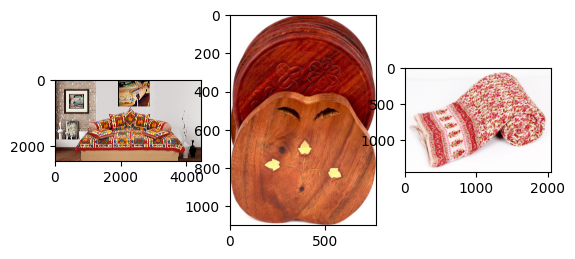

Baby Care 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\601817defaff9d0e30e1b72f96d3975f.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\3cdfd9df09f61a8fd178bafcc8dbed31.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\184ecf07ca4e2872eaf53d2344a1e783.jpg


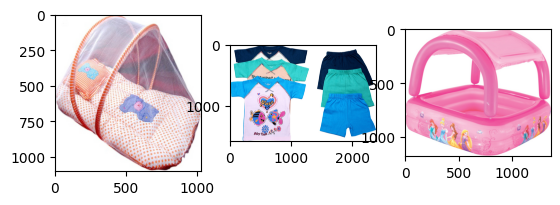

Watches 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\1120bc768623572513df956172ffefeb.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\5479bb7028827d60000720a2c135976a.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\733aa1e801a139fa8dc7be9f0eff5ee0.jpg


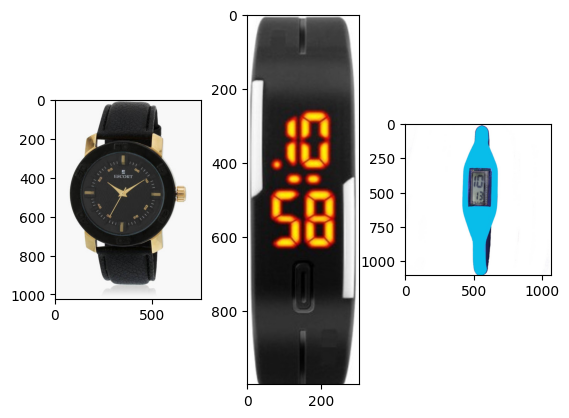

Home Decor & Festive Needs 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\22296bfc1c79d9dc88eabbd01220ef0c.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\f4d4c2eec77732f56e47722d7a355f2b.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\f12a06b7dbfc55638afafcf8bb03d836.jpg


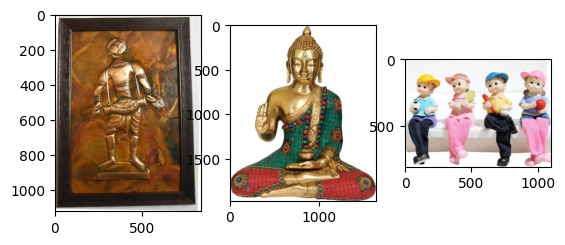

Kitchen & Dining 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\ed9817e8960a6a0d509061c54cfe5ac1.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\5a7a1287fef0d986a5e237797beee286.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\9ba898ecb77ab5a6799c8b047c6b6008.jpg


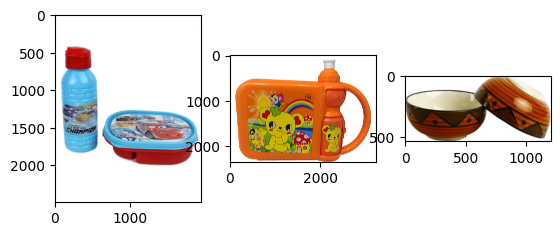

Beauty and Personal Care 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\4942e0a9c0527dc00319a39fc8f103e6.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\5749bae8ccead7997ebf370b6b081d07.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\059493eeb88ebb4cc08d1522f3f87c3f.jpg


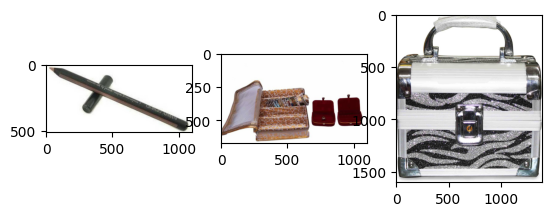

Computers 
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\64b463dc0b75ae40a848498c657041e6.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\c20bf28cd809790c04e78fdaf47c038f.jpg
C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images\fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg


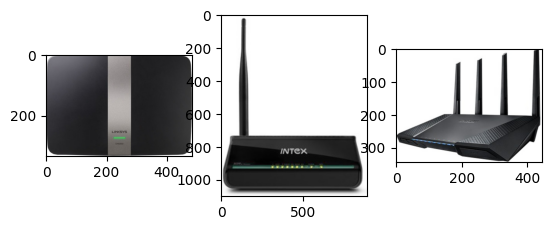

In [ ]:
list_baby = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Baby Care"]
list_beauty = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Beauty and Personal Care"]
list_computers = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Computers"]
list_home = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Home Decor & Festive Needs"]
list_furn = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Home Furnishing"]
list_kitchen = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Kitchen & Dining"]
list_watches = [list_photos[i] for i in range(len(data)) if photo_data["product_category"][i]=="Watches"]

list_labels = photo_data["product_category"].unique().tolist()
list_photos = photo_data["image_path"].unique().tolist()

for name in list_labels:
    print(name)
    for i in range(3):
        filename = os.path.join(path, list_pix(name)[i+10])
        print(filename)
        image = imread(filename)
        plt.subplot(1, 3, i+1)
        plt.imshow(image)
    plt.show()

# 1.6 - Image processing examples

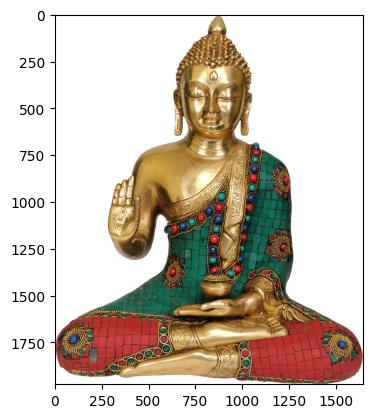

In [ ]:
# Choose image
# sample_image = 'C:/Users/celin/DS Projets Python/PROJET 6/IMAGE Notebooks/flipkart_images/f4d4c2eec77732f56e47722d7a355f2b.jpg'
sample_image = path + '/f4d4c2eec77732f56e47722d7a355f2b.jpg'
image_raw = plt.imshow(imread(sample_image))
image_raw

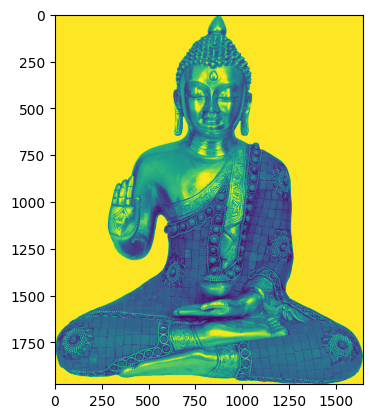

In [ ]:
# Display grayscale image
image_gray =  cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)
plt.imshow(image_gray)

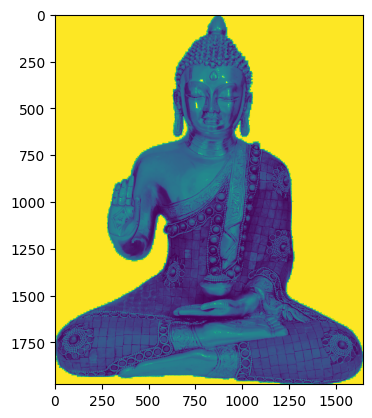

In [ ]:
# Equalize image histogram
image_eq = cv2.equalizeHist(image_gray)
plt.imshow(image_eq)

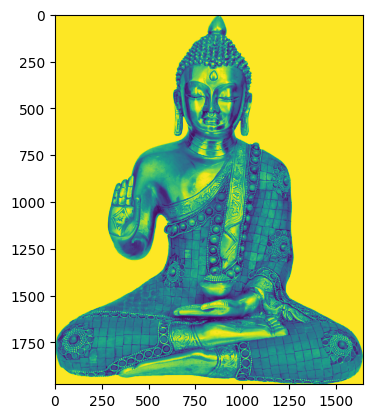

In [ ]:
# Equalize histogram with local contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_clahe = clahe.apply(image_gray)
plt.imshow(image_clahe)

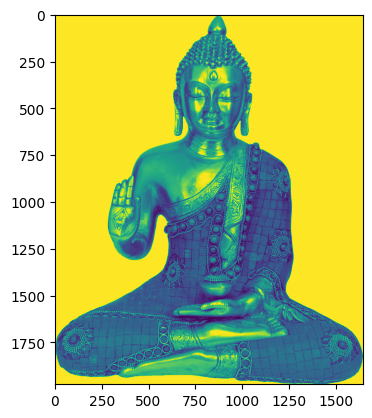

In [ ]:
# Smoothe noise while preserving edges
image_blur = cv2.GaussianBlur(image_gray, (3, 3), 0)
plt.imshow(image_blur)

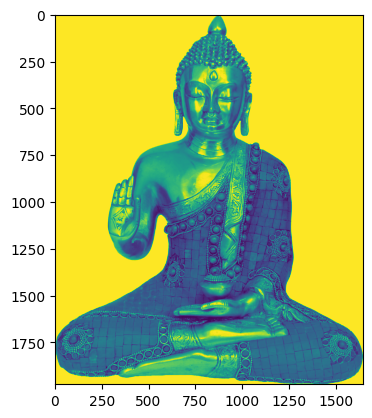

In [ ]:
# Remove salt & pepper noise
image_median = cv2.medianBlur(image_gray, 3)
plt.imshow(image_median)

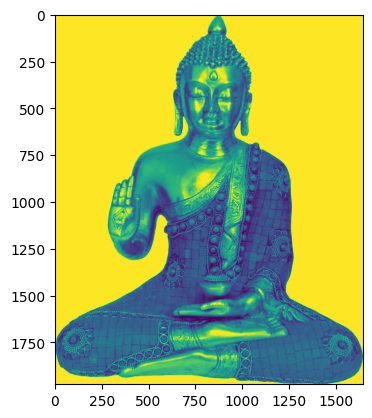

In [ ]:
#  Reduces noise while retaining edges
image_bilateral = cv2.bilateralFilter(image_gray, 9, 75, 75)
plt.imshow(image_bilateral)

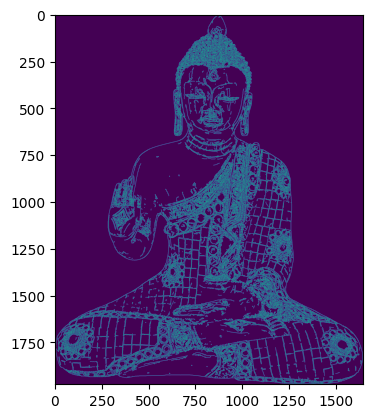

In [ ]:
# Emphasize edges for better keypoint detection
edges = cv2.Canny(image_gray, 100, 200)
plt.imshow(edges)

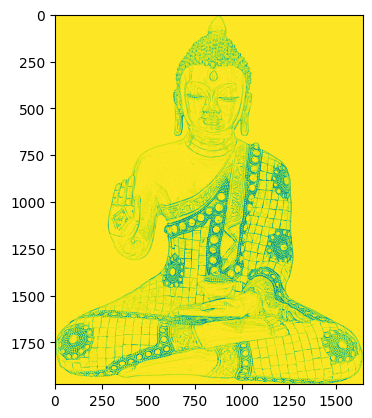

In [ ]:
# Illumination-Invariant Normalization
blurred = cv2.GaussianBlur(image_gray, (0, 0), 3)
image_normalized = cv2.divide(image_gray, blurred, scale=255)
plt.imshow(image_normalized)

# 2 - Local feature extraction

## 2.1 - SIFT (Scale-Invariant Feature Transform)

### 2.1.1 - Base algo

#### 2.1.1.1 - Generate descriptors & features

**SIFT detects and describes local keypoints by analyzing gradient directions in scale-invariant regions. It is robust to rotation, scale, and illumination changes, producing high-quality distinctive features useful for matching and classification. SIFT descriptors are typically 128-dimensional float vectors. See https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html for tuto.**

In [ ]:
# Generate descriptors
sift_keypoints = []
time_2_1_1_1 = time.time()
sift = cv2.SIFT_create()

for image_num in range(len(list_photos)):
    if image_num % 50 == 0:
        print(f'progress : {image_num / len(list_photos) * 100:.2f} %')
    image_path = os.path.join(path, list_photos[image_num])
    image = cv2.imread(image_path, 0)  # grayscale
    if image is None:
        print(f"Could not load image: {image_path}")
        continue  # skip this image
    res = cv2.equalizeHist(image)
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate([d for d in sift_keypoints if d is not None], axis=0)

print("Number of descriptors : ", sift_keypoints_all.shape)
duration_2_1_1_1 = time.time() - time_2_1_1_1
print("Processing time: ", "%15.2f" % duration_2_1_1_1, "secs")

progress : 0.00 %
progress : 4.76 %
progress : 9.52 %
progress : 14.29 %
progress : 19.05 %
progress : 23.81 %
progress : 28.57 %
progress : 33.33 %
progress : 38.10 %
progress : 42.86 %
progress : 47.62 %
progress : 52.38 %
progress : 57.14 %
progress : 61.90 %
progress : 66.67 %
progress : 71.43 %
progress : 76.19 %
progress : 80.95 %
progress : 85.71 %
progress : 90.48 %
progress : 95.24 %
Number of descriptors :  (9051350, 128)
Processing time:           278.52 secs


In [ ]:
# heuristic_k = int(round(np.sqrt(len(sift_keypoints_all)),0))
mbk = MiniBatchKMeans(n_clusters=1000, batch_size=10000, random_state=rs)
mbk.fit(sift_keypoints_all)

MiniBatchKMeans(batch_size=10000, n_clusters=1000, random_state=42)

In [ ]:
# Generate image-level feature vectors (histogrammes)
time_2_1_1_2 = time.time()


def build_histogram(mbk, des, image_num):
    if des is None or len(des) == 0:
        print("Issue with image: ", image_num)
        return np.zeros(len(mbk.cluster_centers_)) # for each image descriptor, assign nearest mbk cluster center (visual word)
    res = mbk.predict(des)
    hist = np.zeros(len(mbk.cluster_centers_))
    nb_des = len(des)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

# build histograms counting how many descriptors fall into each cluster
hist_vectors = []
for i, image_desc in enumerate(sift_keypoints_by_img):  # use sift_keypoints_by_img here
    if i % 100 == 0:
        print(f'progress : {i / len(sift_keypoints_by_img) * 100:.2f} %')
    hist = build_histogram(mbk, image_desc, i)
    hist_vectors.append(hist)

duration_2_1_1_2 = time.time() - time_2_1_1_2
print("Processing time: ", "%15.2f" % duration_2_1_1_2, "secs")

im_features_sift_ba = np.asarray(hist_vectors)

progress : 0.00 %
progress : 9.52 %
progress : 19.05 %
progress : 28.57 %
progress : 38.10 %
progress : 47.62 %
progress : 57.14 %
progress : 66.67 %
progress : 76.19 %
progress : 85.71 %
progress : 95.24 %
Processing time:            70.47 secs


In [ ]:
print(im_features_sift_ba.shape)
im_features_sift_ba

(1050, 1000)


array([[2.15877154e-03, 3.36035192e-04, 1.72090750e-03, ...,
        4.17498269e-04, 2.03657692e-04, 4.37864038e-04],
       [2.98000042e-03, 4.61690206e-04, 8.39436738e-05, ...,
        2.24549327e-03, 3.56760614e-04, 6.29577553e-04],
       [9.44244604e-03, 7.86870504e-04, 3.37230216e-04, ...,
        1.12410072e-03, 1.12410072e-04, 3.37230216e-04],
       ...,
       [1.63185379e-04, 2.28459530e-03, 6.52741514e-04, ...,
        6.52741514e-04, 3.10052219e-03, 3.26370757e-04],
       [5.17368810e-03, 3.69549150e-04, 5.91278640e-03, ...,
        3.69549150e-04, 3.69549150e-04, 0.00000000e+00],
       [6.95168578e-04, 1.73792145e-04, 1.91171359e-03, ...,
        3.47584289e-04, 1.04275287e-03, 3.47584289e-04]])

#### 2.1.1.2 - Descriptors display example with SIFT base algo

**See https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html for tuto.**

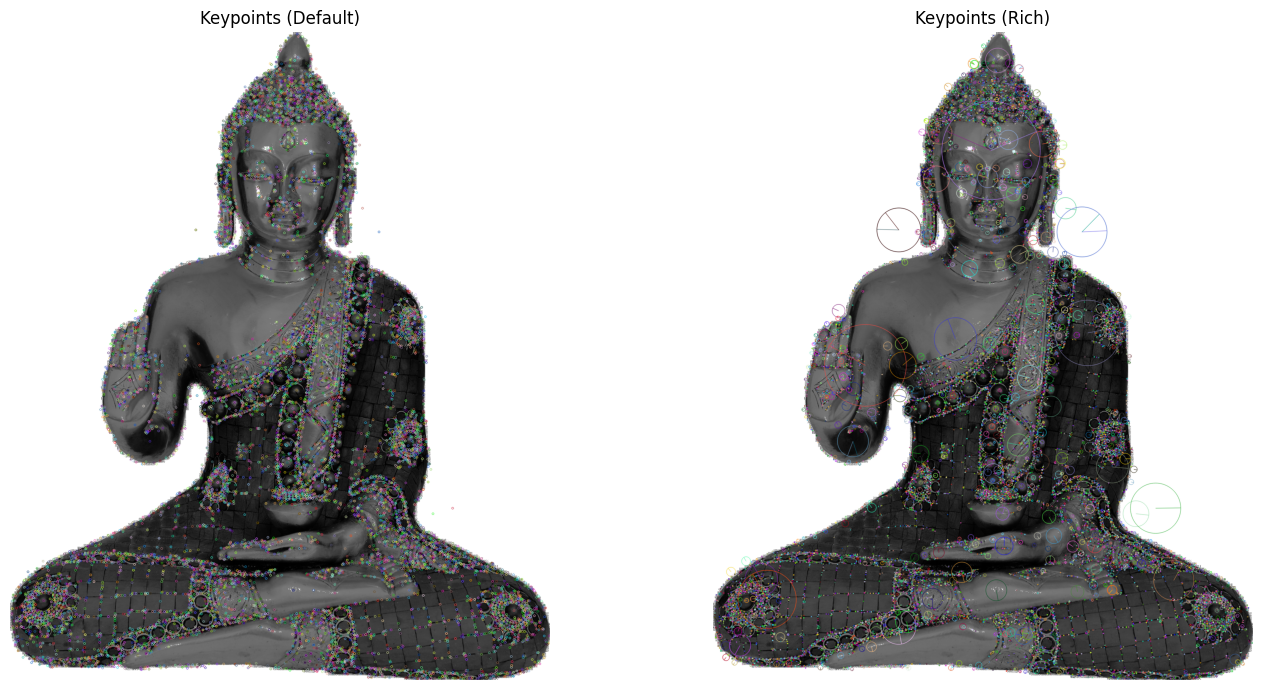

Descriptors shape: (14926, 128)
Processing time:             1.37 secs


In [ ]:
time_1_4 = time.time()
sift = cv2.xfeatures2d.SIFT_create()
# sift = cv2.SIFT_create()  # Uncomment if using OpenCV >= 4.4
# filename = os.path.join(path, list_photos[8])
filename = sample_image
image = cv2.imread(filename, 0)  # Load grayscale
image = cv2.equalizeHist(image)  # Equalize histogram

# Detect keypoints and descriptors
kp, des = sift.detectAndCompute(image, None)

# Draw keypoints with default flags
img1 = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
# Draw keypoints with rich keypoints (size and orientation)
img2 = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Do not draw keypoints without size or orientation
# img3 = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Convert images to RGB for matplotlib (OpenCV uses BGR)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
# fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].imshow(img1_rgb)
axes[0].set_title('Keypoints (Default)')
axes[0].axis('off')

axes[1].imshow(img2_rgb)
axes[1].set_title('Keypoints (Rich)')
axes[1].axis('off')

# axes[2].imshow(img3_rgb)
# axes[2].set_title('Keypoints (Size/Orient)')
# axes[2].axis('off')


# Combine images horizontally for saving
combined_img = np.hstack((img1_rgb, img2_rgb))
# combined_img = np.hstack((img1_rgb, img2_rgb, img3_rgb))

# Save combined image as PNG
plt.savefig(save_path + '/' + "sift_keypoints_comparison.png")

plt.tight_layout()
plt.show()

print("Descriptors shape:", des.shape)
# print()
# print(des)

duration_1_4 = time.time() - time_1_4
print("Processing time: ", f"{duration_1_4:15.2f} secs")

**The sample image contains 14,926 descriptors ; each descriptor is a vector of length = 128.**

#### 2.1.1.3 - PCA

In [ ]:
# Find optimum number of components
(explained_variance_ratio_sift_ba, cumulative_variance_sift_ba, components_sift_ba,
num_components_99_sift_ba, threshold_sift_ba, num_component_threshold_sift_ba, num_component_kaiser_sift_ba,
cumulative_variance_kaiser_sift_ba) = pca_analysis(im_features_sift_ba)

**code above returns (explained_variance_ratio, cumulative_variance, components,
            num_components_99, threshold, num_component_threshold,
            num_component_kaiser, cumulative_variance_kaiser) in that order**

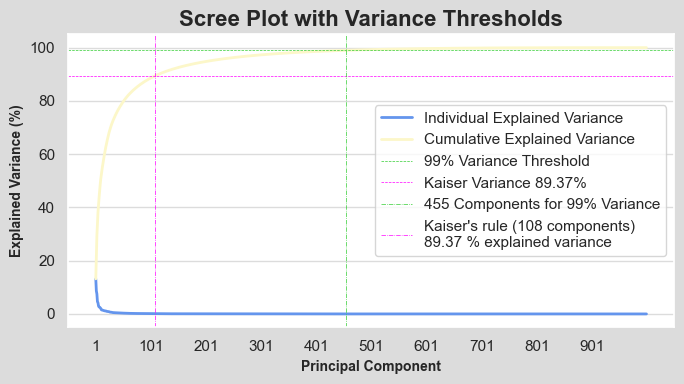

In [ ]:
plot_pca_scree(explained_variance_ratio_sift_ba, cumulative_variance_sift_ba, components_sift_ba,
                   num_components_99_sift_ba, num_component_threshold_sift_ba,
                   num_component_kaiser_sift_ba, cumulative_variance_kaiser_sift_ba,
                   max_ticks=10, save_path=save_path + '/scree_sift_ba.png')

In [ ]:
# pca_sift_ba = decomposition.PCA(n_components=num_component_kaiser_sift_ba, random_state=rs)
pca_sift_ba = decomposition.PCA(n_components=num_components_99_sift_ba, random_state=rs)
feat_pca_sift_ba = pca_sift_ba.fit_transform(im_features_sift_ba)

In [ ]:
print("Dataset dimensions before PCA: ", im_features_sift_ba.shape)
print("Dataset dimensions after PCA: ", feat_pca_sift_ba.shape)

Dataset dimensions before PCA:  (1050, 1000)
Dataset dimensions after PCA:  (1050, 455)


#### 2.1.1.4 - t-SNE & graphical representation

In [ ]:
df_tsne_sift_ba = compute_tsne(feat_pca_sift_ba, photo_data, random_state=rs)
print(df_tsne_sift_ba.head(1))

t-SNE DataFrame shape: (1050, 4)
     tsne1    tsne2  real_clusters          cat_clusters
0 -23.6041 -19.0584              4  4 - Home Furnishing 


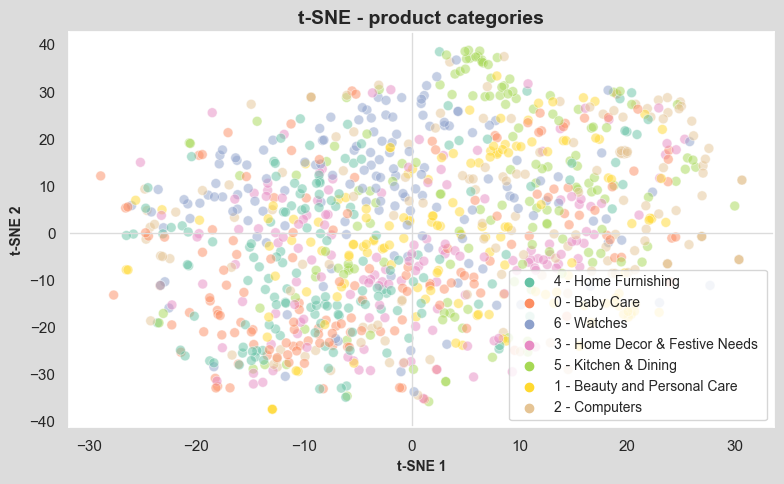

In [ ]:
plot_tsne_clusters(df_tsne_sift_ba, save_path=save_path+'/tsne_clusters_sift_ba')

In [ ]:
# Calculate K-Means
km7_sift_ba = KMeans(n_clusters=7, n_init=100, random_state=rs)
km7_sift_ba.fit(df_tsne_sift_ba[['tsne1', 'tsne2']])
df_tsne_sift_ba['cluster_kmeans'] = km7_sift_ba.labels_
df_tsne_sift_ba.head(1)

tsne1    tsne2  real_clusters          cat_clusters  cluster_kmeans
0 -23.6041 -19.0584              4  4 - Home Furnishing                1

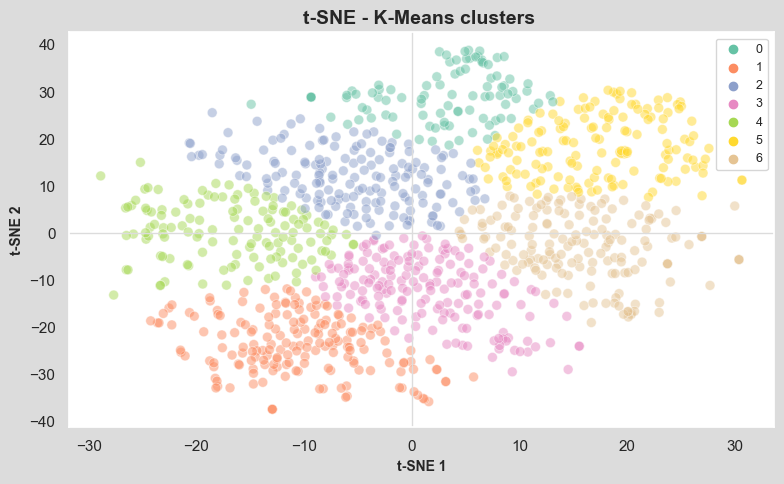

In [ ]:
plot_tsne_kmeans_clusters(df_tsne_sift_ba, save_path=save_path+'/kmeans_clusters_sift_ba')

In [ ]:
# calculate ARI
ARI_sift_ba = metrics.adjusted_rand_score(df_tsne_sift_ba['real_clusters'], df_tsne_sift_ba['cluster_kmeans'])
print(ARI_sift_ba)

# store results
CNN_results.loc[0, 'Fit time'] = (duration_2_1_1_1 + duration_2_1_1_2)
CNN_results.loc[0, 'ARI'] = ARI_sift_ba
CNN_results

0.04557999385874625


Extractor Fit time    ARI
0      SIFT-BA 348.9878 0.0456
1      SIFT-DI      NaN    NaN
2       ORB-BA      NaN    NaN
3       ORB-IP      NaN    NaN
4       VGG-16      NaN    NaN
5       VGG-19      NaN    NaN
6     ResNet50      NaN    NaN
7     Xception      NaN    NaN
8  InceptionV3      NaN    NaN

### 2.1.3 - SIFT on downsampled images

#### 2.1.3.1 - Generate descriptors

In [ ]:
sift_keypoints_di = []
time_2_1_3_1 = time.time()

for image_num in range(len(list_photos)):
    if image_num % 50 == 0:
        print(f'progress : {image_num / len(list_photos) * 100:.2f} %')
    image_path = os.path.join(path, list_photos[image_num])
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not load image: {image_path}")
        sift_keypoints_di.append(None)
        continue  # skip this image

    # Histogram equalization
    res = cv2.equalizeHist(image)

    # Extract SIFT features on downsampled image
    kp, des = sift_on_downsampled(res, downscale_factor=0.5)

    sift_keypoints_di.append(des)

# Filter out None descriptors before concatenation
valid_descriptors_di = [d for d in sift_keypoints_di if d is not None]

sift_keypoints_by_img_di = np.asarray(sift_keypoints_di, dtype=object)
sift_keypoints_all_di = np.concatenate(valid_descriptors_di, axis=0)

print("Number of descriptors : ", sift_keypoints_all_di.shape)
duration_2_1_3_1 = time.time() - time_2_1_3_1
print("Processing time: ", f"{duration_2_1_3_1:15.2f} secs")

progress : 0.00 %
progress : 4.76 %
progress : 9.52 %
progress : 14.29 %
progress : 19.05 %
progress : 23.81 %
progress : 28.57 %
progress : 33.33 %
progress : 38.10 %
progress : 42.86 %
progress : 47.62 %
progress : 52.38 %
progress : 57.14 %
progress : 61.90 %
progress : 66.67 %
progress : 71.43 %
progress : 76.19 %
progress : 80.95 %
progress : 85.71 %
progress : 90.48 %
progress : 95.24 %
Number of descriptors :  (2408526, 128)
Processing time:            78.87 secs


In [ ]:
# heuristic_k = int(round(np.sqrt(len(sift_keypoints_all)),0))
mbk_di = MiniBatchKMeans(n_clusters=1000, batch_size=10000, random_state=rs)
mbk_di.fit(sift_keypoints_all_di)

MiniBatchKMeans(batch_size=10000, n_clusters=1000, random_state=42)

In [ ]:
# Generate image-level feature vectors (histogrammes)
time_2_1_3_2 = time.time()


def build_histogram(mbk, des, image_num):
    if des is None or len(des) == 0:
        print("Issue with image: ", image_num)
        return np.zeros(len(mbk.cluster_centers_)) # for each image descriptor, assign nearest mbk cluster center (visual word)
    res = mbk.predict(des)
    hist = np.zeros(len(mbk.cluster_centers_))
    nb_des = len(des)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

# build histograms counting how many descriptors fall into each cluster
hist_vectors_di = []
for i, image_desc in enumerate(sift_keypoints_by_img_di):  # use sift_keypoints_by_img here
    if i % 100 == 0:
        print(f'progress : {i / len(sift_keypoints_by_img_di) * 100:.2f} %')
    hist_di = build_histogram(mbk, image_desc, i)
    hist_vectors_di.append(hist_di)

duration_2_1_3_2 = time.time() - time_2_1_3_2
print("Processing time: ", "%15.2f" % duration_2_1_3_2, "secs")

im_features_sift_di = np.asarray(hist_vectors_di)

progress : 0.00 %
progress : 9.52 %
progress : 19.05 %
progress : 28.57 %
progress : 38.10 %
progress : 47.62 %
progress : 57.14 %
progress : 66.67 %
progress : 76.19 %
progress : 85.71 %
progress : 95.24 %
Processing time:            17.98 secs


In [ ]:
print(im_features_sift_di.shape)
im_features_sift_di

(1050, 1000)


array([[5.91524188e-03, 2.43092132e-04, 6.88761040e-04, ...,
        1.21546066e-04, 2.02576777e-04, 2.83607487e-04],
       [1.90095998e-03, 0.00000000e+00, 9.50479992e-05, ...,
        1.80591199e-03, 1.90095998e-04, 2.85143998e-04],
       [0.00000000e+00, 6.58327847e-04, 6.58327847e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.32684653e-03, 4.42282176e-04, 4.42282176e-04, ...,
        4.42282176e-04, 1.32684653e-03, 4.42282176e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.45161290e-04, 6.45161290e-04, ...,
        0.00000000e+00, 6.45161290e-04, 0.00000000e+00]])

#### 2.1.3.2 - PCA

In [ ]:
# Find optimum number of components
(explained_variance_ratio_sift_di, cumulative_variance_sift_di, components_sift_di,
num_components_99_sift_di, threshold_sift_di, num_component_threshold_sift_di, num_component_kaiser_sift_di,
cumulative_variance_kaiser_sift_di) = pca_analysis(im_features_sift_di)

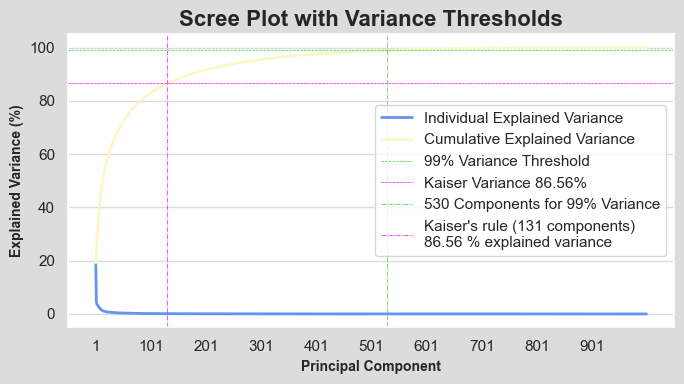

In [ ]:
plot_pca_scree(explained_variance_ratio_sift_di, cumulative_variance_sift_di, components_sift_di,
                   num_components_99_sift_di, num_component_threshold_sift_di,
                   num_component_kaiser_sift_di, cumulative_variance_kaiser_sift_di,
                   max_ticks=10, save_path=save_path + '/scree_sift_di.png')

In [ ]:
# pca_sift_di = decomposition.PCA(n_components=num_component_kaiser_sift_di, random_state=rs)
pca_sift_di = decomposition.PCA(n_components= num_components_99_sift_di, random_state=rs)
feat_pca_sift_di = pca_sift_di.fit_transform(im_features_sift_di)

In [ ]:
print("Dataset dimensions before PCA: ", im_features_sift_di.shape)
print("Dataset dimensions after PCA: ", feat_pca_sift_di.shape)

Dataset dimensions before PCA:  (1050, 1000)
Dataset dimensions after PCA:  (1050, 530)


#### 2.1.3.3 - t-SNE & graphical representation

In [ ]:
df_tsne_sift_di = compute_tsne(feat_pca_sift_di, photo_data, random_state=rs)
print(df_tsne_sift_di.head(1))

t-SNE DataFrame shape: (1050, 4)
     tsne1  tsne2  real_clusters          cat_clusters
0 -24.1996 1.6150              4  4 - Home Furnishing 


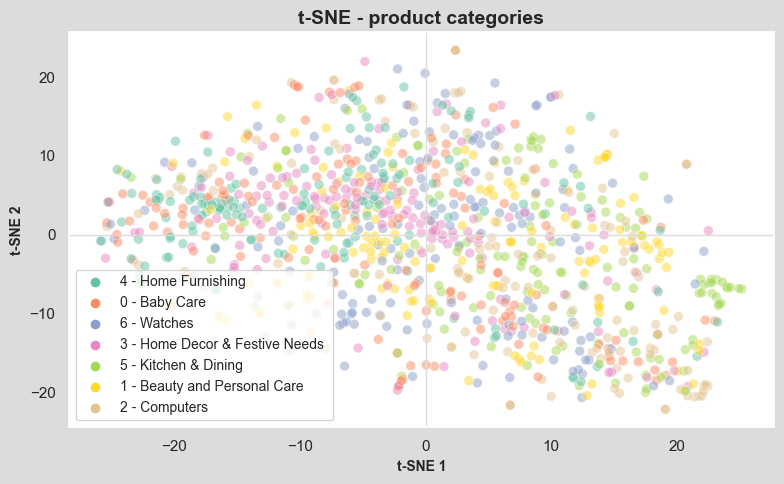

In [ ]:
plot_tsne_clusters(df_tsne_sift_di, save_path=save_path+'/tsne_clusters_sift_di')

In [ ]:
# Calculate K-Means
km7_sift_di = KMeans(n_clusters=7, n_init=100, random_state=rs)
km7_sift_di.fit(df_tsne_sift_di[['tsne1', 'tsne2']])
df_tsne_sift_di['cluster_kmeans'] = km7_sift_di.labels_
df_tsne_sift_di.head(1)

tsne1  tsne2  real_clusters          cat_clusters  cluster_kmeans
0 -24.1996 1.6150              4  4 - Home Furnishing                3

In [ ]:
# Calculate K-Means
km7_sift_di = KMeans(n_clusters=7, n_init=100, random_state=rs)
km7_sift_di.fit(df_tsne_sift_di[['tsne1', 'tsne2']])
df_tsne_sift_di['cluster_kmeans'] = km7_sift_di.labels_
df_tsne_sift_di.head(1)

tsne1  tsne2  real_clusters          cat_clusters  cluster_kmeans
0 -24.1996 1.6150              4  4 - Home Furnishing                3

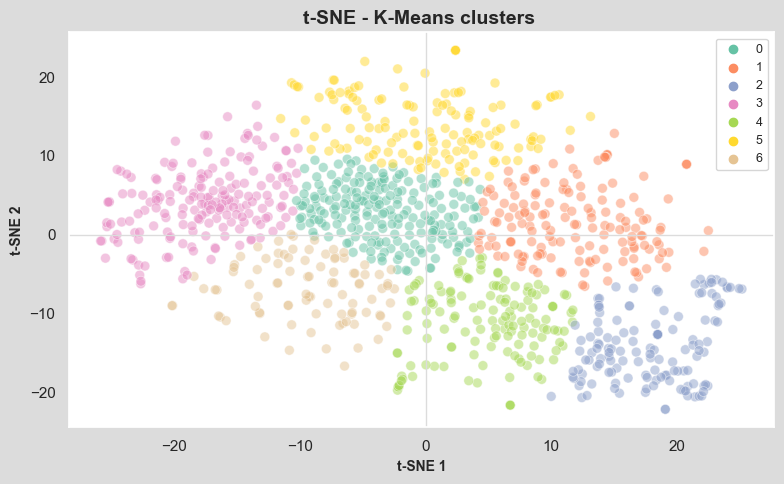

In [ ]:
plot_tsne_kmeans_clusters(df_tsne_sift_di, save_path=save_path+'/kmeans_clusters_sift_di')

In [ ]:
# calculate ARI
ARI_sift_di = metrics.adjusted_rand_score(df_tsne_sift_di['real_clusters'], df_tsne_sift_di['cluster_kmeans'])
print(ARI_sift_di)

# store results
CNN_results.loc[1, 'Fit time'] = (duration_2_1_3_1 + duration_2_1_3_2)
CNN_results.loc[1, 'ARI'] = ARI_sift_di
CNN_results

0.05013874458404786


Extractor Fit time    ARI
0      SIFT-BA 348.9878 0.0456
1      SIFT-DI  96.8513 0.0501
2       ORB-BA      NaN    NaN
3       ORB-IP      NaN    NaN
4       VGG-16      NaN    NaN
5       VGG-19      NaN    NaN
6     ResNet50      NaN    NaN
7     Xception      NaN    NaN
8  InceptionV3      NaN    NaN

## 2.2 - ORB (Oriented FAST and Rotated BRIEF)

**ORB is a faster, lightweight alternative combining FAST keypoint detection with BRIEF descriptors. It produces binary descriptors (256 bits), is rotation invariant, and suitable for real-time applications. ORB is less accurate than SIFT but much faster and patent-free. See https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html for tuto.**

### 2.2.1 - Base algo

#### 2.2.1.1 - Generate descriptors

In [ ]:
orb_keypoints_ba = []
time_2_2_1_1 = time.time()
orb_ba = cv2.ORB_create()

for image_num in range(len(list_photos)):
    if image_num % 50 == 0:
        print(f'progress : {image_num / len(list_photos) * 100:.2f} %')
    image_path = os.path.join(path, list_photos[image_num])
    image = cv2.imread(image_path, 0)  # grayscale
    if image is None:
        print(f"Could not load image: {image_path}")
        continue  # skip this image
    res_ba = cv2.equalizeHist(image)
    kp_ba, des_ba = orb_ba.detectAndCompute(res_ba, None)
    orb_keypoints_ba.append(des_ba)

orb_keypoints_by_img_ba = np.asarray(orb_keypoints_ba, dtype=object)
orb_keypoints_all_ba = np.concatenate([d for d in orb_keypoints_ba if d is not None], axis=0)

print("Number of descriptors : ", orb_keypoints_all_ba.shape)
duration_2_2_1_1 = time.time() - time_2_2_1_1
print("Processing time: ", "%15.2f" % duration_2_2_1_1, "secs")

progress : 0.00 %
progress : 4.76 %
progress : 9.52 %
progress : 14.29 %
progress : 19.05 %
progress : 23.81 %
progress : 28.57 %
progress : 33.33 %
progress : 38.10 %
progress : 42.86 %
progress : 47.62 %
progress : 52.38 %
progress : 57.14 %
progress : 61.90 %
progress : 66.67 %
progress : 71.43 %
progress : 76.19 %
progress : 80.95 %
progress : 85.71 %
progress : 90.48 %
progress : 95.24 %
Number of descriptors :  (520145, 32)
Processing time:            30.18 secs


In [ ]:
num_clusters = 1000
mbk_orb_all_ba= MiniBatchKMeans(n_clusters=num_clusters, batch_size=10000, random_state=42)
mbk_orb_all_ba.fit(orb_keypoints_all_ba)

MiniBatchKMeans(batch_size=10000, n_clusters=1000, random_state=42)

In [ ]:
def build_histogram(mbk, descriptors):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(mbk.n_clusters)
    cluster_assignments = mbk.predict(descriptors)
    hist, _ = np.histogram(cluster_assignments, bins=np.arange(mbk.n_clusters + 1))
    hist = hist / np.linalg.norm(hist, ord=1)  # normalize histogram
    return hist


time_2_2_1_2 = time.time()
histograms_orb_all_ba = []
for des in orb_keypoints_by_img_ba:
    hist_orb_all_ba = build_histogram(mbk_orb_all_ba, des)
    histograms_orb_all_ba.append(hist_orb_all_ba)

duration_2_2_1_2 = time.time() - time_2_2_1_2
print("Processing time: ", "%15.2f" % duration_2_2_1_2, "secs")

im_features_orb_all_ba = np.array(histograms_orb_all_ba)

Processing time:             3.04 secs


#### 2.2.1.2 - PCA

In [ ]:
# Find optimum number of components
(explained_variance_ratio_orb_ba, cumulative_variance_orb_ba, components_orb_ba,
num_components_99_orb_ba, threshold_orb_ba, num_component_threshold_orb_ba, num_component_kaiser_orb_ba,
cumulative_variance_kaiser_orb_ba) = pca_analysis(im_features_orb_all_ba)

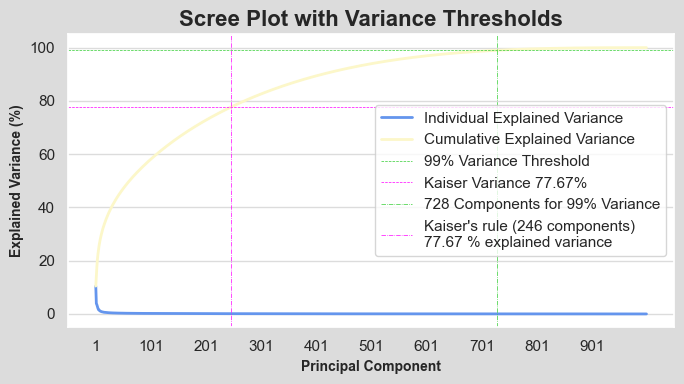

In [ ]:
plot_pca_scree(explained_variance_ratio_orb_ba, cumulative_variance_orb_ba, components_orb_ba,
                   num_components_99_orb_ba, num_component_threshold_orb_ba,
                   num_component_kaiser_orb_ba, cumulative_variance_kaiser_orb_ba,
                   max_ticks=10, save_path=save_path + '/scree_orb_ba.png')

In [ ]:
# pca_orb_ba = decomposition.PCA(n_components=num_component_kaiser_orb_ba, random_state=rs)
pca_orb_ba = decomposition.PCA(n_components=num_components_99_orb_ba, random_state=rs)
feat_pca_orb_ba = pca_orb_ba.fit_transform(im_features_orb_all_ba)

In [ ]:
print("Dataset dimensions before PCA: ", im_features_orb_all_ba.shape)
print("Dataset dimensions after PCA: ", feat_pca_orb_ba.shape)

Dataset dimensions before PCA:  (1050, 1000)
Dataset dimensions after PCA:  (1050, 728)


#### 2.2.1.3 - t-SNE & graphical representation

In [ ]:
df_tsne_orb_ba = compute_tsne(feat_pca_orb_ba, photo_data, random_state=rs)
print(df_tsne_orb_ba.head(1))

t-SNE DataFrame shape: (1050, 4)
    tsne1    tsne2  real_clusters          cat_clusters
0 14.9124 -24.5989              4  4 - Home Furnishing 


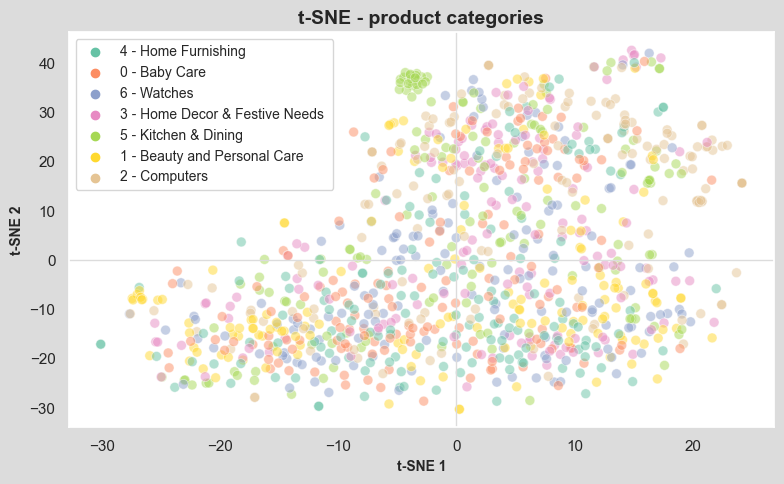

In [ ]:
plot_tsne_clusters(df_tsne_orb_ba, save_path=save_path+'/tsne_clusters_sift_di')

In [ ]:
# Calculate K-Means
km7_orb_ba = KMeans(n_clusters=7, n_init=100, random_state=rs)
km7_orb_ba.fit(df_tsne_orb_ba[['tsne1', 'tsne2']])
df_tsne_orb_ba['cluster_kmeans'] = km7_orb_ba.labels_
df_tsne_orb_ba.head(1)

tsne1    tsne2  real_clusters          cat_clusters  cluster_kmeans
0 14.9124 -24.5989              4  4 - Home Furnishing                2

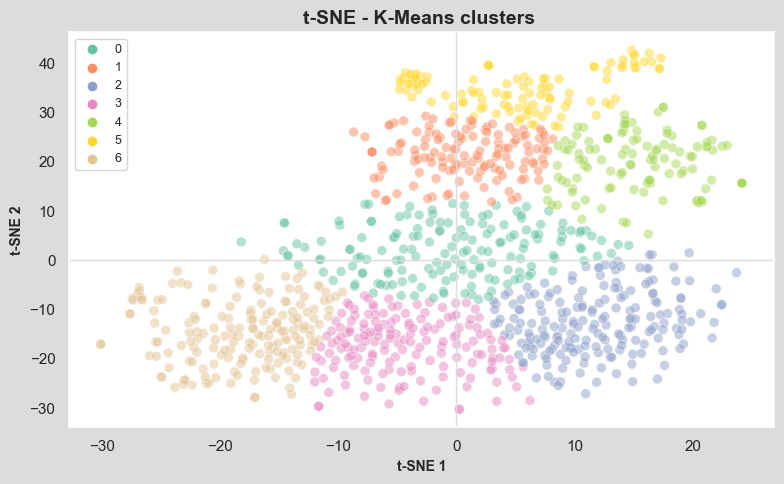

In [ ]:
plot_tsne_kmeans_clusters(df_tsne_orb_ba, save_path=save_path+'/kmeans_clusters_sift_di')

In [ ]:
# calculate ARI
ARI_orb_ba = metrics.adjusted_rand_score(df_tsne_orb_ba['real_clusters'], df_tsne_orb_ba['cluster_kmeans'])
print(ARI_orb_ba)

# store results
CNN_results.loc[2, 'Fit time'] = (duration_2_2_1_1 + duration_2_2_1_2)
CNN_results.loc[2, 'ARI'] = ARI_orb_ba
CNN_results

0.03910407456472381


Extractor Fit time    ARI
0      SIFT-BA 348.9878 0.0456
1      SIFT-DI  96.8513 0.0501
2       ORB-BA  33.2189 0.0391
3       ORB-IP      NaN    NaN
4       VGG-16      NaN    NaN
5       VGG-19      NaN    NaN
6     ResNet50      NaN    NaN
7     Xception      NaN    NaN
8  InceptionV3      NaN    NaN

### 2.2.2 - ORB on image pyramids

#### 2.2.2.1 - Generate descriptors

In [ ]:
def orb_with_pyramids(image, n_levels=3, scale=1.2):
    """Detect ORB features across multiple image scales."""
    orb = cv2.ORB_create()
    keypoints, descriptors = [], []

    for i in range(n_levels):
        # Resize image for current pyramid level
        scaled_image = cv2.resize(image, None, fx=1.0 / (scale ** i), fy=1.0 / (scale ** i))
        kp, des = orb.detectAndCompute(scaled_image, None)

        # Adjust keypoint coordinates to original image scale
        for k in kp:
            k.pt = (k.pt[0] * (scale ** i), k.pt[1] * (scale ** i))

        keypoints.extend(kp)
        if des is not None:
            descriptors.append(des)

    if descriptors:
        descriptors = np.concatenate(descriptors, axis=0)
    else:
        descriptors = None

    return keypoints, descriptors

# Main loop to process all images
orb_keypoints = []
time_2_2_2_1 = time.time()

for image_num in range(len(list_photos)):
    if image_num % 50 == 0:
        print(f'progress : {image_num / len(list_photos) * 100:.2f} %')
    image_path = os.path.join(path, list_photos[image_num])
    image = cv2.imread(image_path, 0)  # grayscale
    if image is None:
        print(f"Could not load image: {image_path}")
        orb_keypoints.append(None)
        continue  # skip this image

    # Histogram equalization
    res = cv2.equalizeHist(image)

    # Extract ORB features with pyramids
    kp, des = orb_with_pyramids(res, n_levels=3, scale=1.2)
    orb_keypoints.append(des)

# Filter out None descriptors before concatenation
valid_descriptors = [d for d in orb_keypoints if d is not None]

if valid_descriptors:
    orb_keypoints_by_img = np.asarray(orb_keypoints, dtype=object)
    orb_keypoints_all = np.concatenate(valid_descriptors, axis=0)
    print()
    print("Number of descriptors : ", orb_keypoints_all.shape)
else:
    print("No descriptors found!")

duration_2_2_2_1 = time.time() - time_2_2_2_1
print("Processing time: ", f"{duration_2_2_2_1:15.2f} secs")

progress : 0.00 %
progress : 4.76 %
progress : 9.52 %
progress : 14.29 %
progress : 19.05 %
progress : 23.81 %
progress : 28.57 %
progress : 33.33 %
progress : 38.10 %
progress : 42.86 %
progress : 47.62 %
progress : 52.38 %
progress : 57.14 %
progress : 61.90 %
progress : 66.67 %
progress : 71.43 %
progress : 76.19 %
progress : 80.95 %
progress : 85.71 %
progress : 90.48 %
progress : 95.24 %

Number of descriptors :  (1545857, 32)
Processing time:            56.46 secs


In [ ]:
num_clusters = 1000
mbk_orb_all_ip= MiniBatchKMeans(n_clusters=num_clusters, batch_size=10000, random_state=42)
mbk_orb_all_ip.fit(orb_keypoints_all)

MiniBatchKMeans(batch_size=10000, n_clusters=1000, random_state=42)

In [ ]:
def build_histogram(mbk, descriptors):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(mbk.n_clusters)
    cluster_assignments = mbk.predict(descriptors)
    hist, _ = np.histogram(cluster_assignments, bins=np.arange(mbk.n_clusters + 1))
    hist = hist / np.linalg.norm(hist, ord=1)  # normalize histogram
    return hist


time_2_2_2_2 = time.time()

histograms_orb_all_ip = []
for des in orb_keypoints_by_img_ba:
    hist_orb_all_ip = build_histogram(mbk_orb_all_ip, des)
    histograms_orb_all_ip.append(hist_orb_all_ip)

duration_2_2_2_2 = time.time() - time_2_2_2_2
print("Processing time: ", "%15.2f" % duration_2_2_2_2, "secs")

im_features_orb_all_ip = np.array(histograms_orb_all_ip)

Processing time:             3.22 secs


#### 2.2.2.2 - PCA

In [ ]:
# Find optimum number of components
(explained_variance_ratio_orb_ip, cumulative_variance_orb_ip, components_orb_ip,
num_components_99_orb_ip, threshold_orb_ip, num_component_threshold_orb_ip, num_component_kaiser_orb_ip,
cumulative_variance_kaiser_orb_ip) = pca_analysis(im_features_orb_all_ip)

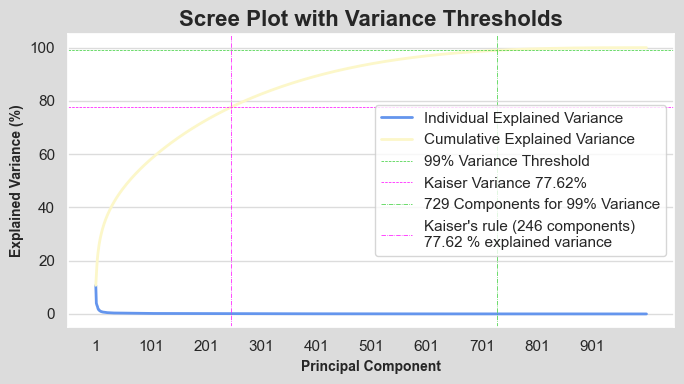

In [ ]:
plot_pca_scree(explained_variance_ratio_orb_ip, cumulative_variance_orb_ip, components_orb_ip,
                   num_components_99_orb_ip, num_component_threshold_orb_ip,
                   num_component_kaiser_orb_ip, cumulative_variance_kaiser_orb_ip,
                   max_ticks=10, save_path=save_path + '/scree_orb_ip.png')

In [ ]:
# pca_orb_ip = decomposition.PCA(n_components=num_component_kaiser_orb_ip, random_state=rs)
pca_orb_ip = decomposition.PCA(n_components=num_components_99_orb_ip, random_state=rs)
feat_pca_orb_ip = pca_orb_ip.fit_transform(im_features_orb_all_ip)

In [ ]:
print("Dataset dimensions before PCA: ", im_features_orb_all_ip.shape)
print("Dataset dimensions after PCA: ", feat_pca_orb_ip.shape)

Dataset dimensions before PCA:  (1050, 1000)
Dataset dimensions after PCA:  (1050, 729)


#### 2.2.2.3 - t-SNE & graphical representation

In [ ]:
df_tsne_orb_ip = compute_tsne(feat_pca_orb_ip, photo_data, random_state=rs)
print(df_tsne_orb_ip.head(1))

t-SNE DataFrame shape: (1050, 4)
     tsne1  tsne2  real_clusters          cat_clusters
0 -18.0869 0.3432              4  4 - Home Furnishing 


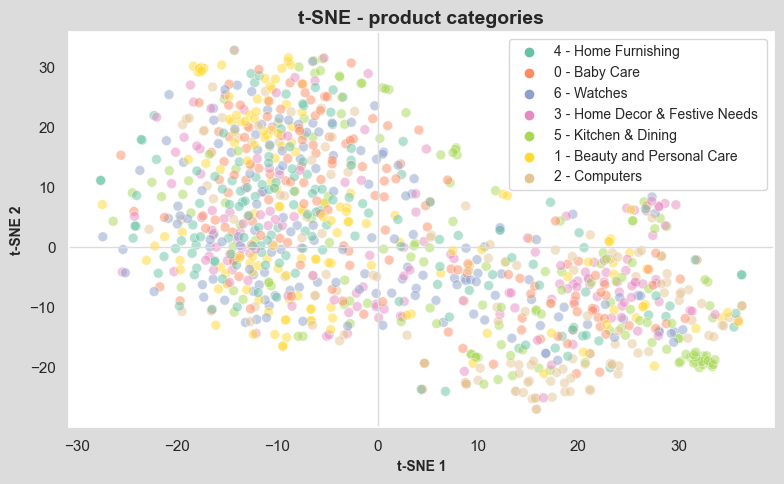

In [ ]:
plot_tsne_clusters(df_tsne_orb_ip, save_path=save_path+'/tsne_clusters_orb_ip')

In [ ]:
# Calculate K-Means
km7_orb_ip = KMeans(n_clusters=7, n_init=100, random_state=rs)
km7_orb_ip.fit(df_tsne_orb_ip[['tsne1', 'tsne2']])
df_tsne_orb_ip['cluster_kmeans'] = km7_orb_ip.labels_
df_tsne_orb_ip.head(1)

tsne1  tsne2  real_clusters          cat_clusters  cluster_kmeans
0 -18.0869 0.3432              4  4 - Home Furnishing                1

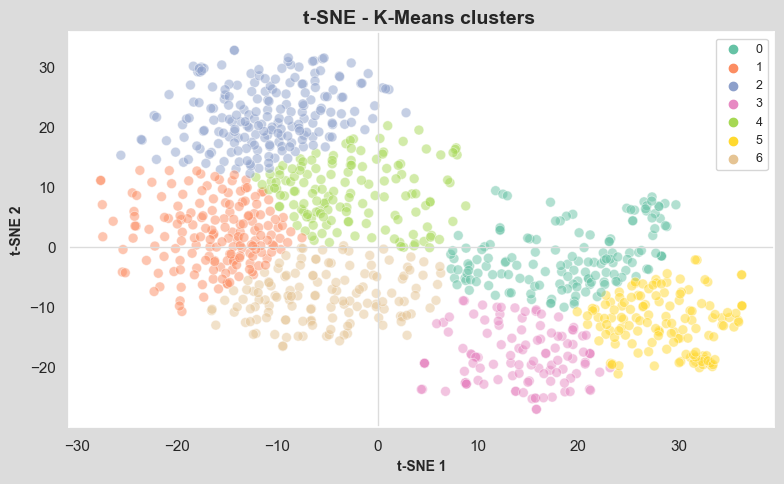

In [ ]:
plot_tsne_kmeans_clusters(df_tsne_orb_ip, save_path=save_path+'/kmeans_clusters_orb_ip')

In [ ]:
# calculate ARI
ARI_orb_ip = metrics.adjusted_rand_score(df_tsne_orb_ip['real_clusters'], df_tsne_orb_ip['cluster_kmeans'])
print(ARI_orb_ip)

# store results
CNN_results.loc[3, 'Fit time'] = (duration_2_2_2_1 + duration_2_2_2_2)
CNN_results.loc[3, 'ARI'] = ARI_orb_ip
CNN_results

0.029879690421825703


Extractor Fit time    ARI
0      SIFT-BA 348.9878 0.0456
1      SIFT-DI  96.8513 0.0501
2       ORB-BA  33.2189 0.0391
3       ORB-IP  59.6772 0.0299
4       VGG-16      NaN    NaN
5       VGG-19      NaN    NaN
6     ResNet50      NaN    NaN
7     Xception      NaN    NaN
8  InceptionV3      NaN    NaN

## 2.3 - SURF (Speeded Up Robust Features)

- SURF is a local feature detector and descriptor used in computer vision for tasks such as object recognition, image registration, classification, and 3D reconstruction. SURF was developed to be a faster alternative to SIFT (Scale-Invariant Feature Transform) while maintaining comparable robustness and accuracy. See https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html for tuto.
- SURF could not be tested due to the patented nature of the algorithm (code below requires a paid subscription to run).

In [ ]:
# surf_keypoints = []
# time_2_1_2 = time.time()
# surf = cv2.xfeatures2d.SURF_create()

# for image_num in range(len(list_photos)):
#     if image_num % 50 == 0:
#         print(f'progress : {image_num / len(list_photos) * 100:.2f} %')
#     image_path = os.path.join(path, list_photos[image_num])
#     image = cv2.imread(image_path, 0)  # grayscale
#     if image is None:
#         print(f"Could not load image: {image_path}")
#         continue  # skip this image
#     res = cv2.equalizeHist(image)
#     kp, des = surf.detectAndCompute(res, None)
#     surf_keypoints.append(des)

# surf_keypoints_by_img = np.asarray(surf_keypoints, dtype=object)
# surf_keypoints_all = np.concatenate([d for d in surf_keypoints if d is not None], axis=0)

# print()
# print("Number of descriptors : ", surf_keypoints_all.shape)
# duration_2_1_2 = time.time() - time_2_1_2
# print("Processing time: ", "%15.2f" % duration_2_1_2, "secs")

# 3 - Transfer learning feature extraction

**Reminder : Run notebook in Google Colab from here onwards - will not run in a Windows environment.**

**Convolutional neural networks**
* CNNs are still the most efficient models for image classification. They have a methodology similar to traditional supervised learning methods: they receive images as input, detect the features of each image, and then train a classifier on them. However, the features are learned automatically. CNNs perform the feature extraction and description work themselves: during the training phase, the classification error is minimized to optimize the classifier parameters and features. Unlike supervised learning techniques, convolutional neural networks learn the features of each image. This is where their strength lies: networks perform feature extraction automatically, unlike machine learning techniques;  
* For classification problems, the network calculates a score (or probability) for each class from the input. The class assigned to the input object corresponds to the class with the highest score;  
* CNNs are a subcategory of neural networks. However, CNNs are specifically designed to process input images. Their architecture is therefore more specific and comprises two main blocks:
* The first block is unique to this type of neural network, as it functions as a feature extractor. To do this, it performs template matching by applying convolutional filtering operations. The first layer filters the image with several convolution kernels and returns feature maps, which are then normalized (with an activation function) and/or resized. This process can be repeated several times: the resulting feature maps are filtered with new kernels, which gives us new feature maps to normalize and resize, and which can then be filtered again, and so on. Finally, the values of the last feature maps are concatenated into a vector. This vector defines the output of the first block and the input of the second;  
* The second block is not characteristic of a CNN: it is actually found at the end of all neural networks used for classification. The values of the input vector are transformed (with several linear combinations and activation functions) to return a new output vector. This vector contains as many elements as there are classes: element i represents the probability that the image belongs to class i. Each element is therefore between 0 and 1, and the sum of all elements is equal to 1. These probabilities are calculated by the last layer of this block (and therefore of the network), which uses a logistic function (binary classification) or a softmax function (multi-class classification) as the activation function;  
* As with ordinary neural networks, the layer parameters are determined by gradient backpropagation: cross-entropy is minimized during the training phase. But in the case of CNNs, these parameters specifically designate the image features.

**Transfer learning**
* Transfer learning consists in taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify koalas may be useful to kick-start a model meant to identify wombats or other marsupials. Transfer learning is usually done for tasks where the available dataset has too little data to train a full-scale model from scratch;  
* The most common incarnation of transfer learning in the context of deep learning is the following workflow:
* Take layers from a previously trained model;  
* Freeze them, so as to avoid destroying any of the information they contain during future training rounds;  
* Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset; and    
* Train the new layers on the available dataset.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
path = '/content/drive/My Drive/Colab Notebooks/OCDS_P6/flipkart_images'
save_path = '/content/drive/My Drive/Colab Notebooks/OCDS_P6'

In [81]:
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [82]:
data = pd.read_parquet(save_path + '/products_trim_final.parquet.gzip')
photo_data = data[['image', 'product_category', 'real_clusters']]
photo_data = photo_data.rename(columns={'image' : 'image_path'})
print(photo_data.shape)
photo_data.head()

(1050, 3)


image_path  product_category  real_clusters
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing               4
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care               0
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care               0
3  d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing               4
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing               4

## 3.1 - Baseline model : transfer learning with VGG16

**What is `VGG16`?**  
VGG-16 (Visual Geometry Group, University of Oxford), a version of the well-known convolutional neural network called VGG-Net. The VGG16 model is composed of 16 layers (13 convolutional layers and 3 fully connected layers) and is trained on the ImageNet dataset, which includes over a million images divided into 1,000 classes.

- `VGG16()` loads the **VGG16** convolutional neural network architecture with pretrained weights (usually on ImageNet).
- VGG16 is a deep CNN consisting of **16 weight layers**: 13 convolutional layers and 3 fully connected layers.
- The input to VGG16 is typically an image of size 224×224×3 (RGB).
- The architecture uses small 3×3 convolution filters stacked in increasing depth, with max pooling layers reducing spatial dimensions.
- The final layers are three fully connected (dense) layers: two with 4096 neurons and one with 1000 neurons for classification into ImageNet classes.

---

**What does `Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)` do?**

- This creates a new Keras model that **shares the same input layer as the original VGG16** (`base_model.inputs`).
- Instead of outputting the final classification layer, it outputs the activations from the **second last layer** (`base_model.layers[-2].output`).
- In VGG16, the second last layer is the **penultimate fully connected layer** with 4096 neurons.
- This layer’s output is a 4096-dimensional feature vector representing high-level image features before classification.
- This technique is often used for **feature extraction** or **transfer learning**, where you want to use the learned image representations without the final classification layer.

---

**Why use this model setup?**

- By extracting features from the penultimate layer, a rich, high-level representation of the input image is obtained ;
- These features can be used for tasks like clustering, image retrieval, or as input to another classifier tailored to the specific problem at hand ;
- It avoids retraining the entire network and leverages the pretrained knowledge learned from large datasets like ImageNet.

### 3.1.1 - Instanciate model

In [138]:
base_model_16 = VGG16()
model_16 = Model(inputs=base_model_16.inputs, outputs=base_model_16.layers[-2].output)
model_16.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1.2 - Extract features on whole dataset

In [139]:
temps_1 = time.time()

images_features_16 = []
i=0
for image_num in range(len(list_photos)) :
    if i%100 == 0 :
        print(f'progress : {i / len(list_photos) * 100:.2f} %')
    i +=1
    image = load_img(path+'/'+list_photos[image_num], target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features_16.append(model_16.predict(image, verbose=0)[0])

    duration_1 = time.time() - temps_1
print("Features creation time with VGG-16 : ", "%15.2f" % duration_1, "secs")

images_features_16 = np.asarray(images_features_16)
images_features_16.shape

progress : 0.00 %
progress : 9.52 %
progress : 19.05 %
progress : 28.57 %
progress : 38.10 %
progress : 47.62 %
progress : 57.14 %
progress : 66.67 %
progress : 76.19 %
progress : 85.71 %
progress : 95.24 %
Features creation time with VGG-16 :            95.54 secs


(1050, 4096)

In [1]:
CNN_results.loc[4, 'Fit time'] = duration_1
# CNN_results

### 3.1.3 - PCA dimensionality reduction

In [141]:
# pca_VGG_16 = decomposition.PCA(n_components=num_component_kaiser_VGG_16, random_state=rs)
pca_VGG_16 = decomposition.PCA(n_components=0.99, random_state=rs)
feat_pca_VGG_16 = pca_VGG_16.fit_transform(images_features_16)

In [142]:
print("Dataset dimensions before PCA reduction : ", images_features_16.shape)
print("Dataset dimensions after PCA reduction : ", feat_pca_VGG_16.shape)

Dataset dimensions before PCA reduction :  (1050, 4096)
Dataset dimensions after PCA reduction :  (1050, 803)


### 3.1.4 - t-SNE dimensionality reduction

In [143]:
print("Dataset dimensions before PCA reduction : ", images_features_16.shape)
# pca_19 = decomposition.PCA(n_components=0.99)
pca_16 = decomposition.PCA(n_components=0.99, random_state=rs)
X_VGG16_pca= pca_16.fit_transform(images_features_16)
print("Dataset dimensions after PCA reduction : ", X_VGG16_pca.shape)

Dataset dimensions before PCA reduction :  (1050, 4096)
Dataset dimensions after PCA reduction :  (1050, 803)


In [144]:
df_tsne_VGG16=[]
tsne_16 = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, init='random', random_state=42)
X_tsne_VGG16 = tsne_16.fit_transform(X_VGG16_pca)
df_tsne_VGG16 = pd.DataFrame(X_tsne_VGG16[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_VGG16['image_name_jpg']=list_photos
df_tsne_VGG16=pd.merge(df_tsne_VGG16,data.loc[:,['image','product_category','real_clusters']],
                       left_on='image_name_jpg', right_on='image', how='left')
df_tsne_VGG16.head(1)

tsne1  tsne2                        image_name_jpg  \
0 12.6162 7.8181  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  
0              3

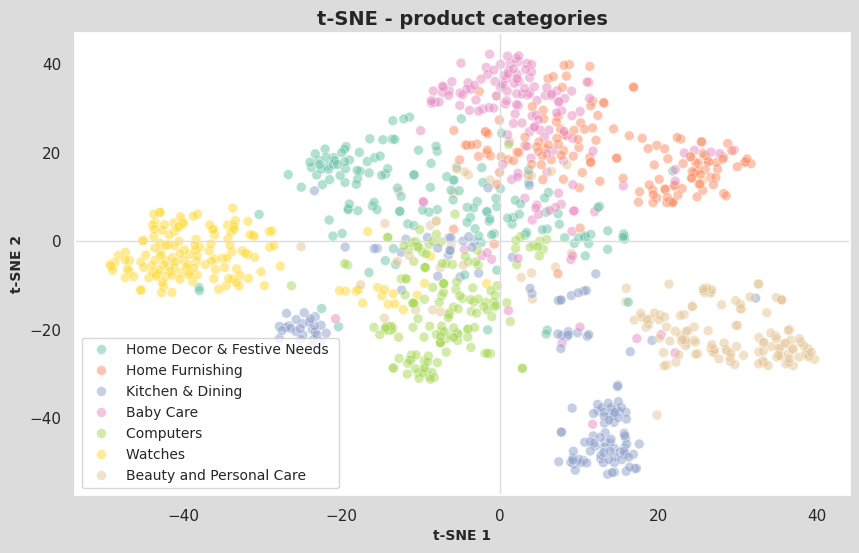

In [145]:
# plot t-SNE with real product categories
sns.set(rc={'figure.figsize':(10,6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
sns.scatterplot(
    x="tsne1", y="tsne2", hue="product_category", data=df_tsne_VGG16, legend='brief', palette=sns.color_palette('Set2', n_colors=7),
    s=50, alpha=0.5)
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.title('t-SNE - product categories', fontsize = 14, fontweight = 'bold')
plt.xlabel('t-SNE 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10},loc='best')
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/VGG16_product_cats.png')

In [146]:
# Calculate K-Means
cls_vgg16 = KMeans(n_clusters=7, n_init=100, random_state=42)
cls_vgg16.fit(X_tsne_VGG16)
df_tsne_VGG16['cluster_kmeans'] = cls_vgg16.labels_
df_tsne_VGG16.head(1)

tsne1  tsne2                        image_name_jpg  \
0 12.6162 7.8181  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  cluster_kmeans  
0              3               1

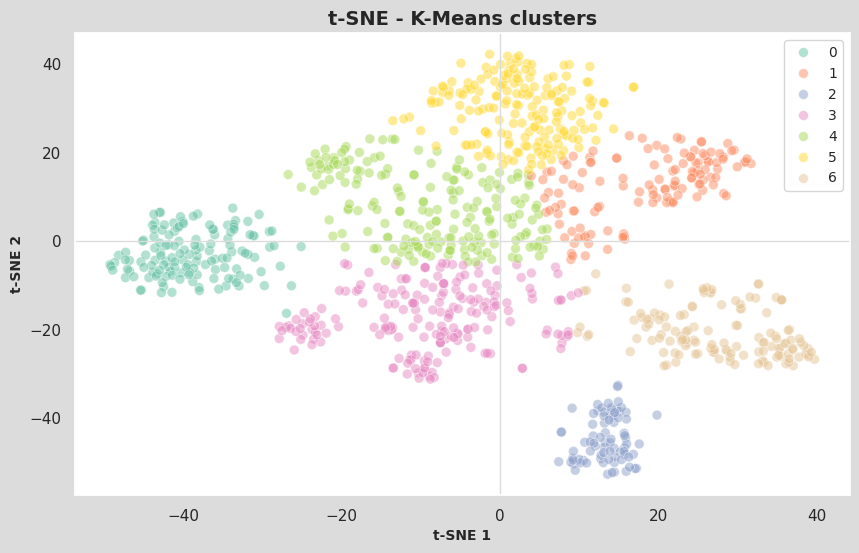

In [147]:
# plot t-SNE with K-Means cluster numbers
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1", y="tsne2",hue='cluster_kmeans', palette=sns.color_palette('Set2', n_colors=7), s=50, alpha=0.5,
                data=df_tsne_VGG16, legend="brief")
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.title('t-SNE - K-Means clusters', fontsize = 14, fontweight = 'bold')
plt.xlabel('t-SNE 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10})
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/VGG16_kmeans_clusters.png')

In [148]:
# calculate ARI
ARI_VGG16 =  np.round(metrics.adjusted_rand_score(df_tsne_VGG16["real_clusters"].values, cls_vgg16.labels_),4)
CNN_results.loc[4, 'ARI'] = ARI_VGG16
print("Score ARI : ", ARI_VGG16)

Score ARI :  0.466


## 3.2 - Transfer learning with VGG19

**What is `VGG19`?**  
VGG19 is a deep convolutional neural network developed by the Visual Geometry Group at the University of Oxford as a variant of the VGGNet architecture. The VGG19 model consists of 19 weight layers—specifically, 16 convolutional layers and 3 fully connected layers—and is trained on the ImageNet dataset, which contains over a million images across 1,000 classes. 

- `VGG19()` loads the **VGG19** convolutional neural network architecture with pretrained weights (typically from ImageNet).
- VGG19 is a deep CNN comprising **19 weight layers**: 16 convolutional layers and 3 fully connected layers.
- The input to VGG19 is typically an image of size 224×224×3 (RGB).
- The architecture uses small 3×3 convolution filters stacked in depth, with max pooling layers to reduce spatial dimensions, and ReLU activations after each convolution.
- The final layers are three fully connected (dense) layers: two with 4096 neurons each and one with 1000 neurons for ImageNet classification, followed by a softmax for output.

---

**What does `Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)` do?**

- This creates a new Keras model that **shares the same input layer as the original VGG19** (`base_model.inputs`).
- Instead of outputting the final classification layer, it outputs the activations from the **second last layer** (`base_model.layers[-2].output`).
- In VGG19, the second last layer is the **penultimate fully connected layer** with 4096 neurons.
- This layer’s output is a 4096-dimensional feature vector representing high-level image features before classification.
- This approach is often used for **feature extraction** or **transfer learning**, leveraging the pretrained model’s learned representations without the final classification step.

---

**Why use this model setup?**

- By extracting features from the penultimate layer, you obtain a rich, high-level representation of the input image.
- These features are valuable for tasks such as clustering, image retrieval, or as input to another classifier tailored to a specific problem.
- This method leverages the pretrained knowledge from large datasets like ImageNet and avoids retraining the entire network, saving time and computational resources.

### 3.2.1 - Instanciate model

In [150]:
base_model_19 = VGG19()
model_19 = Model(inputs=base_model_19.inputs, outputs=base_model_19.layers[-2].output)
model_19.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 139,570,240 (532.42 MB)

 Trainable params: 139,570,240 (532.42 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2.2 - Extract features on whole dataset

In [151]:
temps_2 = time.time()

images_features_19 = []
i=0
for image_num in range(len(list_photos)) :
    if i%100 == 0 :
      print(f'progress : {i / len(list_photos) * 100:.2f} %')
    i +=1
    image = load_img(path+'/'+list_photos[image_num], target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    image = preprocess_input(image)
    images_features_19.append(model_19.predict(image, verbose=0)[0])

    duration_2 = time.time() - temps_2
print("Features creation time with VGG-19 : ", "%15.2f" % duration_2, "secs")
CNN_results.loc[5, 'Fit time'] = duration_2
images_features_19 = np.asarray(images_features_19)
images_features_19.shape

progress : 0.00 %
progress : 9.52 %
progress : 19.05 %
progress : 28.57 %
progress : 38.10 %
progress : 47.62 %
progress : 57.14 %
progress : 66.67 %
progress : 76.19 %
progress : 85.71 %
progress : 95.24 %
Features creation time with VGG-19 :           104.82 secs


(1050, 4096)

### 3.2.3 - PCA dimensionality reduction

In [153]:
print("Dataset dimensions before PCA reduction : ", images_features_19.shape)
pca_19 = decomposition.PCA(n_components=0.99, random_state=rs)
X_VGG19_pca= pca_19.fit_transform(images_features_19)
print("Dataset dimensions after PCA reduction : ", X_VGG19_pca.shape)

Dataset dimensions before PCA reduction :  (1050, 4096)
Dataset dimensions after PCA reduction :  (1050, 796)


### 3.2.4 - t-SNE dimensionality reduction

In [154]:
df_tsne_VGG19=[]
tsne_19 = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, init='random', random_state=rs)
X_tsne_VGG19 = tsne_19.fit_transform(X_VGG19_pca)
df_tsne_VGG19 = pd.DataFrame(X_tsne_VGG19[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_VGG19['image_name_jpg']=list_photos
df_tsne_VGG19=pd.merge(df_tsne_VGG19,data.loc[:,['image','product_category','real_clusters']],
                       left_on='image_name_jpg', right_on='image', how='left')
df_tsne_VGG19.head(1)

tsne1   tsne2                        image_name_jpg  \
0 -6.5644 23.9623  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  
0              3

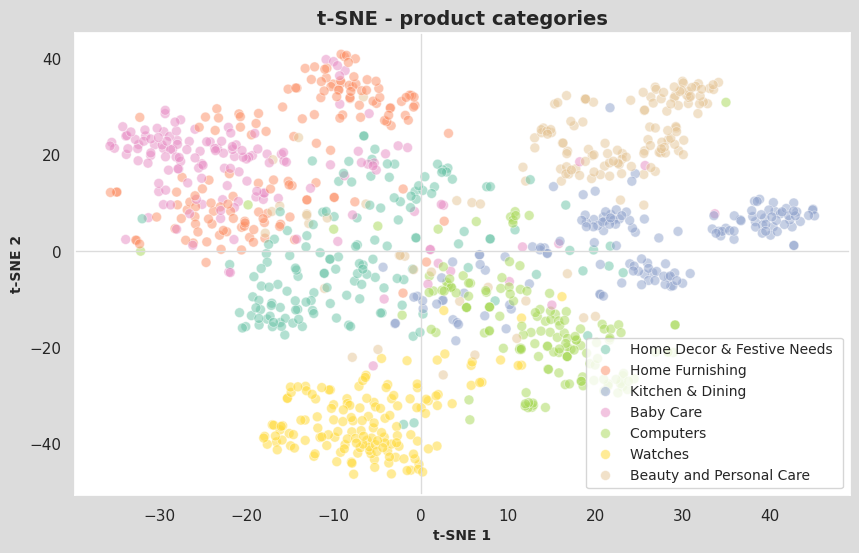

<Figure size 1000x600 with 0 Axes>

In [155]:
# plot t-SNE with real product categories
sns.set(rc={'figure.figsize':(10,6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
sns.scatterplot(x="tsne1", y="tsne2", hue="product_category", data=df_tsne_VGG19, legend='brief',
                palette=sns.color_palette('Set2', n_colors=7), s=50, alpha=0.5)
plt.title('t-SNE - product categories', fontsize = 14, fontweight = 'bold')
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.xlabel('t-SNE 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10},loc='best')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/VGG19_product_cats.png')

In [156]:
# Calculate K-Means
cls_vgg19 = KMeans(n_clusters=7, n_init=100, random_state=rs)
cls_vgg19.fit(X_tsne_VGG19)
df_tsne_VGG19['cluster_kmeans'] = cls_vgg19.labels_
df_tsne_VGG19.head(1)

tsne1   tsne2                        image_name_jpg  \
0 -6.5644 23.9623  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  cluster_kmeans  
0              3               5

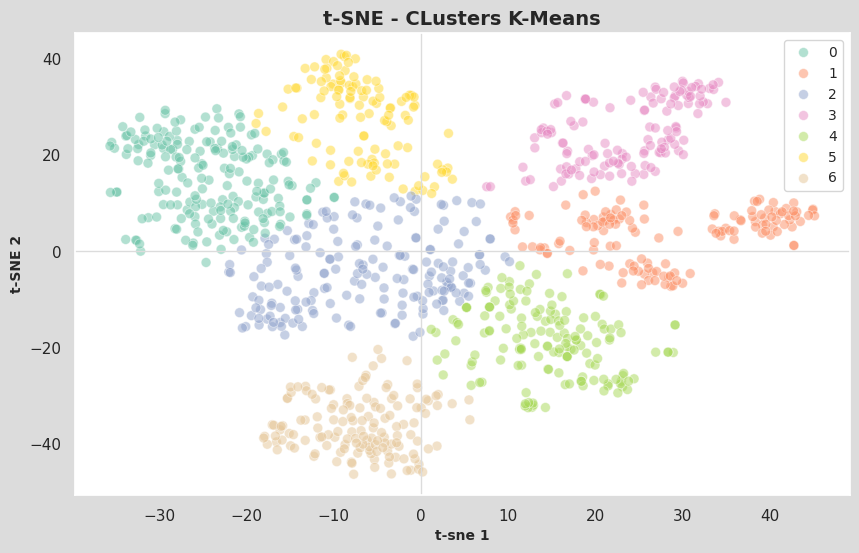

<Figure size 1000x600 with 0 Axes>

In [157]:
# plot t-SNE with K-Means cluster numbers
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1", y="tsne2", hue='cluster_kmeans', palette=sns.color_palette('Set2', n_colors=7),
                s=50, alpha=0.5, data=df_tsne_VGG19, legend="brief")
plt.title('t-SNE - CLusters K-Means', fontsize = 14, fontweight = 'bold')
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.xlabel('t-sne 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10})
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/VGG19_kmeans_clusters.png')

In [14]:
# calculate ARI
ARI_VGG19 =  np.round(metrics.adjusted_rand_score(df_tsne_VGG19["real_clusters"].values, cls_vgg19.labels_),4)
CNN_results.loc[5, 'ARI'] = ARI_VGG19
print("Score ARI : ", ARI_VGG19)

Score ARI :  0.5215


## 3.3 - Transfer Learning with ResNet50

**What is `ResNet50`?**  
ResNet50 is a deep convolutional neural network introduced by Microsoft Research Asia in 2015 as part of the Residual Network (ResNet) family. The model is composed of 50 layers: 48 convolutional layers, one max pooling layer, and one average pooling layer. ResNet50 is trained on the ImageNet dataset, which contains over a million images across 1,000 classes. Its key innovation is the use of residual blocks with skip connections, allowing the network to learn residual functions and effectively train much deeper architectures without suffering from vanishing gradients or degradation in performance. The architecture uses 3×3 convolutional filters in bottleneck blocks and employs global average pooling before the final dense layer.

- `ResNet50()` loads the **ResNet50** architecture with pretrained weights (typically from ImageNet).
- ResNet50 consists of **50 layers**: 48 convolutional layers, 1 max pooling layer, and 1 average pooling layer.
- The input to ResNet50 is typically an image of size 224×224×3 (RGB).
- The architecture is built from residual blocks, each containing convolutional layers and skip connections that add the input to the output of the block.
- Instead of fully connected layers at the end, ResNet50 uses global average pooling, followed by a dense layer with 1000 neurons for ImageNet classification.

### 3.3.1 - Instanciate model

In [160]:
# Load ResNet50 pretrained on ImageNet, exclude top classification layer, use global average pooling
base_model_50 = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# The model outputs a 2048-dimensional feature vector per image
model_50 = base_model_50

print(model_50.summary())

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


### 3.3.2 - Extract features on whole dataset

In [161]:
temps_3 = time.time()

images_features_50 = []
i=0
for image_num in range(len(list_photos)) :
    if i%100 == 0 :
      print(f'progress : {i / len(list_photos) * 100:.2f} %')
    i +=1
    image = load_img(path+'/'+list_photos[image_num], target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    image = preprocess_input(image)
    images_features_50.append(model_50.predict(image, verbose=0)[0])

    duration_3 = time.time() - temps_3
print("Features creation time with RN50 : ", "%15.2f" % duration_3, "secs")
CNN_results.loc[6, 'Fit time'] = duration_3
images_features_50 = np.asarray(images_features_50)
images_features_50.shape

progress : 0.00 %
progress : 9.52 %
progress : 19.05 %
progress : 28.57 %
progress : 38.10 %
progress : 47.62 %
progress : 57.14 %
progress : 66.67 %
progress : 76.19 %
progress : 85.71 %
progress : 95.24 %
Features creation time with RN50 :            98.08 secs


(1050, 2048)

### 3.3.3 - PCA dimensionality reduction

In [163]:
print("Dataset dimensions before PCA reduction : ", images_features_50.shape)
pca_50 = decomposition.PCA(n_components=0.99)
X_RN50_pca= pca_50.fit_transform(images_features_50)
print("Dataset dimensions after PCA reduction : ", X_RN50_pca.shape)

Dataset dimensions before PCA reduction :  (1050, 2048)
Dataset dimensions after PCA reduction :  (1050, 722)


### 3.3.4 - t-SNE dimensionality reduction

In [164]:
df_tsne_RN50=[]
tsne_50 = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, init='random',
                        random_state=rs)
X_tsne_RN50 = tsne_50.fit_transform(X_RN50_pca)
df_tsne_RN50 = pd.DataFrame(X_tsne_RN50[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_RN50['image_name_jpg']=list_photos
df_tsne_RN50=pd.merge(df_tsne_RN50,data.loc[:,['image','product_category','real_clusters']],
                       left_on='image_name_jpg', right_on='image', how='left')
df_tsne_RN50.head(1)

tsne1   tsne2                        image_name_jpg  \
0 29.7745 10.2754  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  
0              3

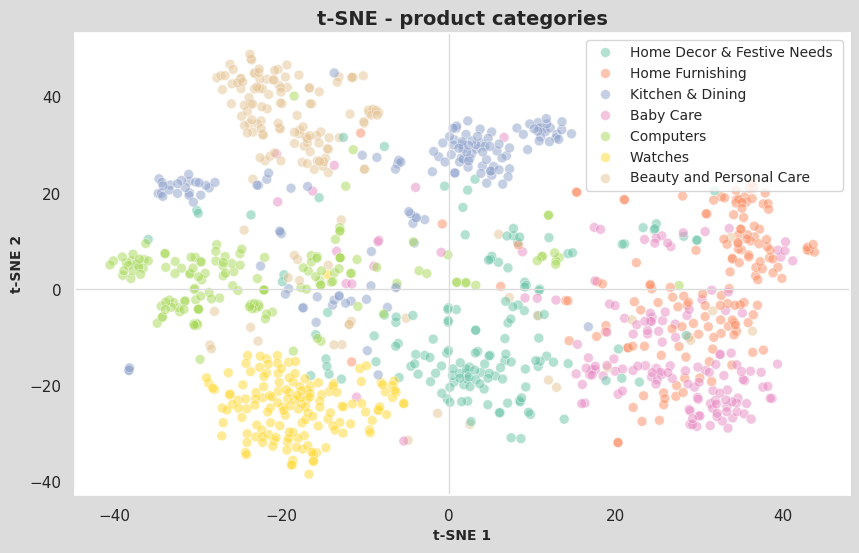

<Figure size 1000x600 with 0 Axes>

In [165]:
# plot t-SNE with real product categories
sns.set(rc={'figure.figsize':(10,6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
sns.scatterplot(x="tsne1", y="tsne2", hue="product_category", data=df_tsne_RN50, legend='brief',
                palette=sns.color_palette('Set2', n_colors=7), s=50, alpha=0.5)
plt.title('t-SNE - product categories', fontsize = 14, fontweight = 'bold')
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.xlabel('t-SNE 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10},loc='best')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/RN50_product_cats.png')

In [166]:
# Calculate K-Means
cls_RN50 = KMeans(n_clusters=7, n_init=100, random_state=rs)
cls_RN50.fit(X_tsne_RN50)
df_tsne_RN50['cluster_kmeans'] = cls_RN50.labels_
df_tsne_RN50.head(1)

tsne1   tsne2                        image_name_jpg  \
0 29.7745 10.2754  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  cluster_kmeans  
0              3               6

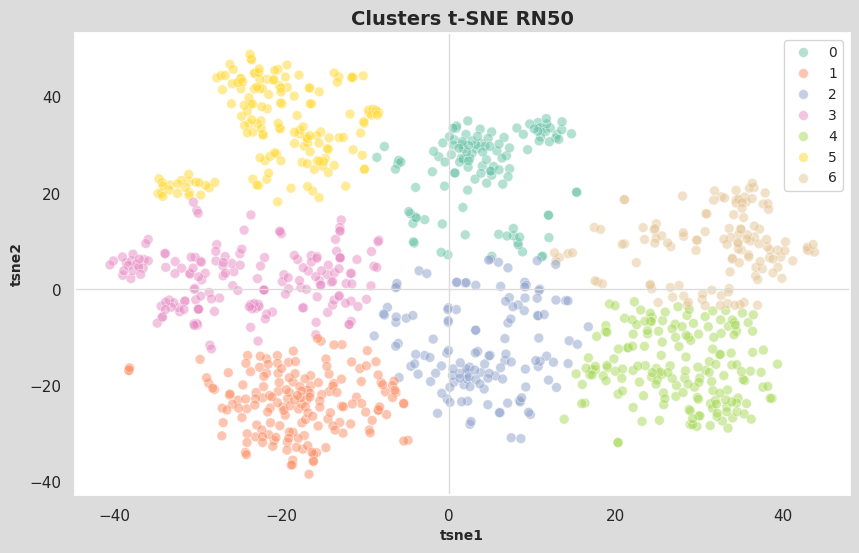

<Figure size 1000x600 with 0 Axes>

In [167]:
# plot t-SNE with K-Means cluster numbers
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1", y="tsne2", hue='cluster_kmeans', palette=sns.color_palette('Set2', n_colors=7),
                s=50, alpha=0.5, data=df_tsne_RN50, legend="brief")
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.title('Clusters t-SNE RN50', fontsize = 14, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 10, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10})
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/RN50_kmeans_clusters.png')

In [13]:
# calculate ARI
ARI_RN50 =  np.round(metrics.adjusted_rand_score(df_tsne_RN50["real_clusters"].values, cls_RN50.labels_),4)
CNN_results.loc[6, 'ARI'] = ARI_RN50
print("Score ARI : ", ARI_RN50)

Score ARI :  0.5554


## 3.4 - Transfer learning with Xception

**What is `Xception`?**  
Xception (Extreme Inception) is a deep convolutional neural network architecture developed by François Chollet at Google, building on the Inception family of models. Unlike Inception, which uses parallel convolutional filters of different sizes, Xception replaces these modules with depthwise separable convolutions—operations that first apply a single filter to each input channel (depthwise convolution) and then combine outputs using pointwise (1×1) convolutions. The Xception model is structured into three main parts: the entry flow, middle flow, and exit flow, with a total of 36 convolutional layers that leverage skip connections for efficient training and gradient flow.

- `Xception()` loads the **Xception** architecture with pretrained weights (typically from ImageNet).
- Xception is a deep CNN with **depthwise separable convolutional layers** and skip connections, organized into 36 main convolutional layers (not counting batch normalization and activation layers).
- The input to Xception is typically an image of size 299×299×3 (RGB).
- The architecture is divided into entry flow (downsampling and initial feature extraction), middle flow (repeated feature refinement), and exit flow (final feature aggregation and classification).
- The final layers include global average pooling and a fully connected (dense) layer with 1000 neurons for ImageNet classification.

### 3.4.1 - Instanciate model

In [170]:
# Load Xception model (pretrained on ImageNet)
base_xception = Xception(weights='imagenet', include_top=False, pooling='avg')
print(base_xception.summary())

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_13[0… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_196[0][0]  │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_24[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

None


### 3.4.2 - Extract features on whole dataset

In [171]:
# Extract features using Xception (input size 299x299)
temps_0 = time.time()
features_xception = extract_features_from_list(base_xception, xception_preprocess, list_photos, path, target_size=(299, 299))
duration_0 = time.time() - temps_0
CNN_results.loc[7, 'Fit time'] = duration_0
print("Features creation time with Xception : ", "%15.2f" % duration_0, "secs")
print("Xception features shape:", features_xception.shape)

Processing image 0/1050
Processing image 100/1050
Processing image 200/1050
Processing image 300/1050
Processing image 400/1050
Processing image 500/1050
Processing image 600/1050
Processing image 700/1050
Processing image 800/1050
Processing image 900/1050
Processing image 1000/1050
Features creation time: 100.34 secs
Features creation time with Xception :           100.35 secs
Xception features shape: (1050, 2048)


### 3.4.3 - PCA dimensionality reduction

In [173]:
print("Dataset dimensions before PCA reduction : ", features_xception.shape)
pca_xcep = decomposition.PCA(n_components=0.99)
X_xcep_pca= pca_xcep.fit_transform(features_xception)
print("Dataset dimensions after PCA reduction : ", X_xcep_pca.shape)

Dataset dimensions before PCA reduction :  (1050, 2048)
Dataset dimensions after PCA reduction :  (1050, 745)


### 3.4.4 - t-SNE dimensionality reduction

In [174]:
df_tsne_xcep=[]
tsne_xcep = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, init='random', random_state=42)
X_tsne_xcep = tsne_xcep.fit_transform(X_xcep_pca)
df_tsne_xcep = pd.DataFrame(X_tsne_xcep[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_xcep['image_name_jpg']=list_photos
df_tsne_xcep=pd.merge(df_tsne_xcep,data.loc[:,['image','product_category','real_clusters']],
                       left_on='image_name_jpg', right_on='image', how='left')
df_tsne_xcep.head(1)

tsne1   tsne2                        image_name_jpg  \
0 -6.4479 15.3308  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  
0              3

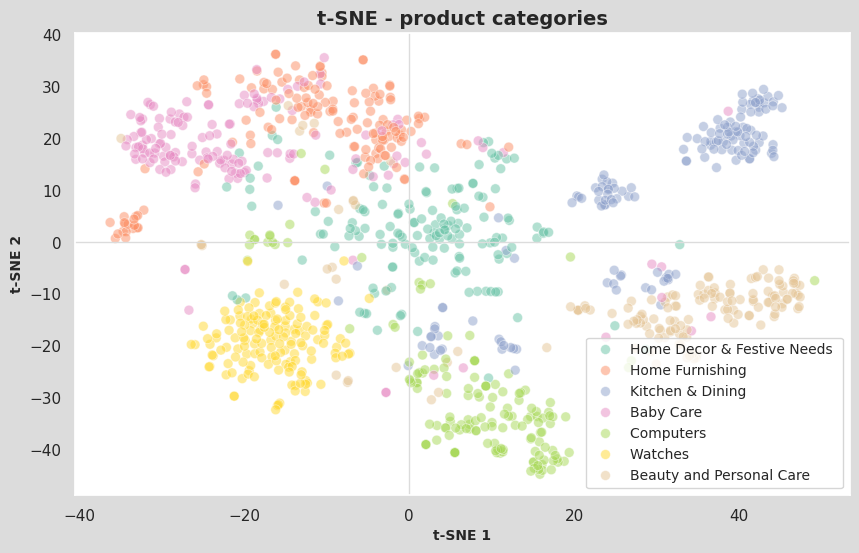

<Figure size 1000x600 with 0 Axes>

In [175]:
# plot t-SNE with real product categories
sns.set(rc={'figure.figsize':(10,6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
sns.scatterplot(x="tsne1", y="tsne2", hue="product_category", data=df_tsne_xcep, legend='brief',
                palette=sns.color_palette('Set2', n_colors=7), s=50, alpha=0.5)
plt.title('t-SNE - product categories', fontsize = 14, fontweight = 'bold')
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.xlabel('t-SNE 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10},loc='best')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/xcep_product_cats.png')

In [176]:
# Calculate K-Means
cls_xcep = KMeans(n_clusters=7,n_init=100, random_state=42)
cls_xcep.fit(X_tsne_xcep)
df_tsne_xcep['cluster_kmeans'] = cls_xcep.labels_
df_tsne_xcep.head(1)

tsne1   tsne2                        image_name_jpg  \
0 -6.4479 15.3308  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  cluster_kmeans  
0              3               3

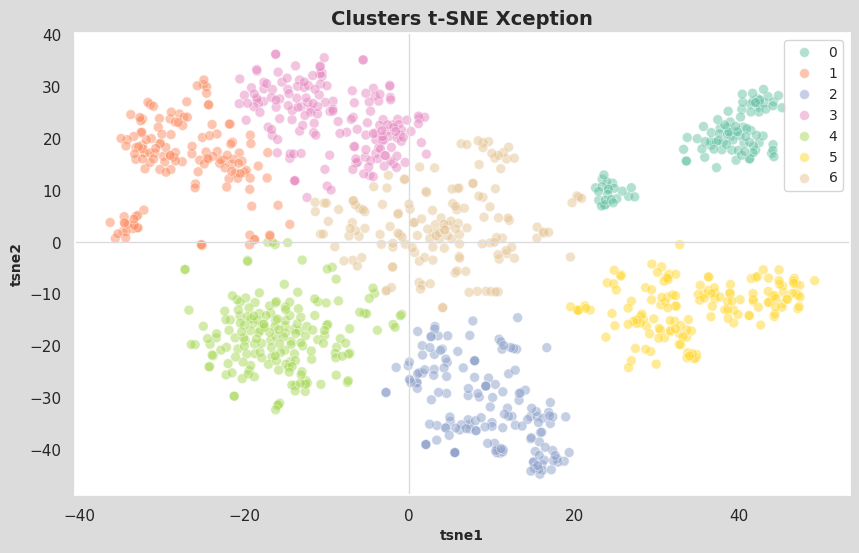

<Figure size 1000x600 with 0 Axes>

In [177]:
# plot t-SNE with K-Means cluster numbers
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1", y="tsne2", hue='cluster_kmeans', palette=sns.color_palette('Set2', n_colors=7),
                s=50, alpha=0.5, data=df_tsne_xcep, legend="brief")
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.title('Clusters t-SNE Xception', fontsize = 14, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 10, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10})
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/xcep_kmeans_clusters.png')

In [12]:
# calculate ARI
ARI_xcep =  np.round(metrics.adjusted_rand_score(df_tsne_xcep["real_clusters"].values, df_tsne_xcep['cluster_kmeans']),4)
CNN_results.loc[7, 'ARI'] = ARI_xcep
print("Score ARI : ", ARI_xcep)

Score ARI :  0.5431


## 3.5 - Transfer learning with InceptionV3

**What is `InceptionV3`?**  
InceptionV3 is a deep convolutional neural network architecture developed by Google as an evolution of the original Inception (GoogLeNet) models. Introduced in 2015, InceptionV3 incorporates several optimizations for efficiency and performance, including factorization of larger convolutions into smaller ones, use of asymmetric convolutions, auxiliary classifiers as regularizers, and efficient grid size reduction. The model is typically composed of 42 to 48 layers, depending on the counting method, and is trained on the ImageNet dataset, which contains over a million images across 1,000 classes. The standard input size for InceptionV3 is 299×299×3 (RGB). Its modular architecture uses parallel convolutional layers of different sizes within each Inception module, allowing the network to be both deep and computationally efficient.

- `InceptionV3()` loads the **InceptionV3** architecture with pretrained weights (commonly from ImageNet).
- InceptionV3 consists of **42–48 layers** (depending on counting), including multiple Inception modules with parallel convolutions, pooling, and auxiliary classifiers.
- The input image size is typically 299×299×3.
- The architecture uses factorized convolutions, asymmetric convolutions, and efficient grid size reduction to optimize computational cost and performance.
- The final layers include a global average pooling layer and a dense (fully connected) layer with 1,000 neurons for ImageNet classification.

### 3.5.1 - Instanciate model

In [180]:
# Load InceptionV3 model (pretrained on ImageNet)
base_inception = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
print(base_inception.summary())

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_200 (Conv2D) │ (None, None,      │        864 │ input_layer_14[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_200[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_201 (Conv2D) │ (None, None,      │      9,216 │ activation_188[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_201[0][0]  │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, None,      │     18,432 │ activation_189[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_202[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, None,      │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, None,      │      5,120 │ max_pooling2d_8[… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, None,      │    138,240 │ activation_191[0… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


### 3.5.2 - Extract features on whole dataset

In [181]:
# Extract features using InceptionV3 (input size 299x299)
temps_0_0 = time.time()
features_inception = extract_features_from_list(base_inception, inception_preprocess, list_photos, path, target_size=(299, 299))
duration_0_0 = time.time() - temps_0_0
CNN_results.loc[8, 'Fit time'] = duration_0_0
print("Features creation time with XceptionV3 : ", "%15.2f" % duration_0_0, "secs")
print("InceptionV3 features shape:", features_inception.shape)

Processing image 0/1050
Processing image 100/1050
Processing image 200/1050
Processing image 300/1050
Processing image 400/1050
Processing image 500/1050
Processing image 600/1050
Processing image 700/1050
Processing image 800/1050
Processing image 900/1050
Processing image 1000/1050
Features creation time: 112.67 secs
Features creation time with XceptionV3 :           112.68 secs
InceptionV3 features shape: (1050, 2048)


### 3.5.3 - PCA dimensionality reduction

In [183]:
print("Dataset dimensions before PCA reduction : ", features_inception.shape)
pca_ncep = decomposition.PCA(n_components=0.99)
X_ncep_pca= pca_ncep.fit_transform(features_inception)
print("Dataset dimensions after PCA reduction : ", X_ncep_pca.shape)

Dataset dimensions before PCA reduction :  (1050, 2048)
Dataset dimensions after PCA reduction :  (1050, 696)


### 3.5.4 - t-SNE dimensionality reduction

In [184]:
df_tsne_ncep=[]
tsne_ncep = manifold.TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=2000, init='random', random_state=42)
X_tsne_ncep = tsne_ncep.fit_transform(X_xcep_pca)
df_tsne_ncep = pd.DataFrame(X_tsne_ncep[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_ncep['image_name_jpg']=list_photos
df_tsne_ncep=pd.merge(df_tsne_ncep,data.loc[:,['image','product_category','real_clusters']],
                       left_on='image_name_jpg', right_on='image', how='left')
df_tsne_ncep.head(1)

tsne1   tsne2                        image_name_jpg  \
0 -6.4479 15.3308  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  
0              3

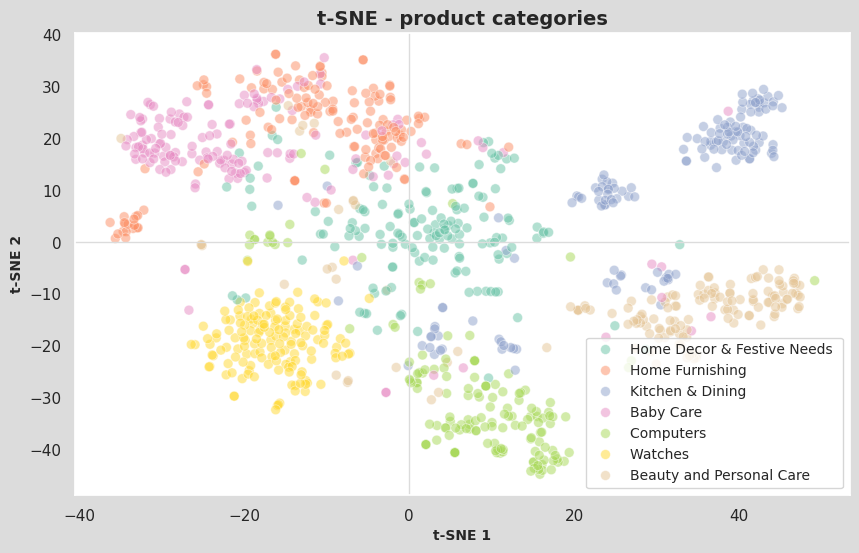

<Figure size 1000x600 with 0 Axes>

In [185]:
# plot t-SNE with real product categories
sns.set(rc={'figure.figsize':(10,6), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
sns.scatterplot(x="tsne1", y="tsne2", hue="product_category", data=df_tsne_ncep, legend='brief',
                palette=sns.color_palette('Set2', n_colors=7), s=50, alpha=0.5)
plt.title('t-SNE - product categories', fontsize = 14, fontweight = 'bold')
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.xlabel('t-SNE 1', fontsize = 10, fontweight = 'bold')
plt.ylabel('t-SNE 2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10},loc='best')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/ncep_product_cats.png')

In [186]:
# Calculate K-Means
cls_ncep = KMeans(n_clusters=7,n_init=100, random_state=42)
cls_ncep.fit(X_tsne_xcep)
df_tsne_ncep['cluster_kmeans'] = cls_ncep.labels_
df_tsne_ncep.head(1)

tsne1   tsne2                        image_name_jpg  \
0 -6.4479 15.3308  0ae859a69c7608d8197c3ba8c37bc6ec.jpg   

                                  image             product_category  \
0  0ae859a69c7608d8197c3ba8c37bc6ec.jpg  Home Decor & Festive Needs    

   real_clusters  cluster_kmeans  
0              3               3

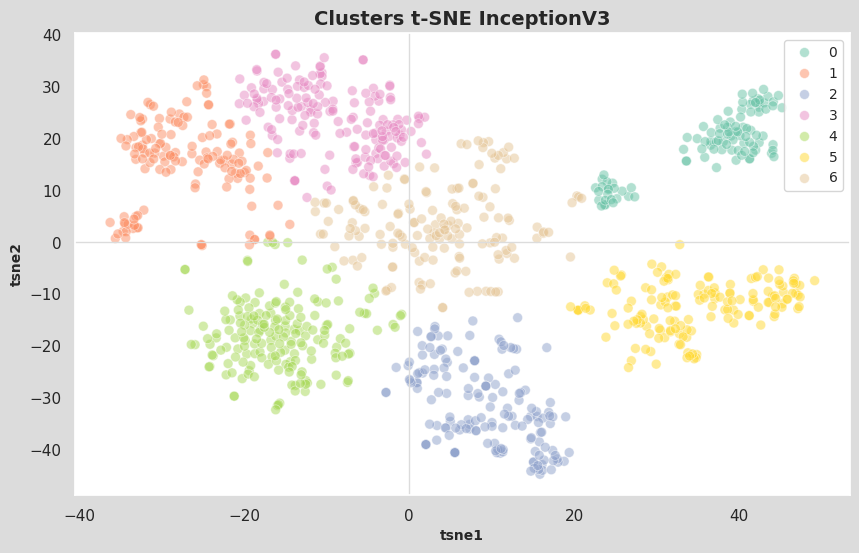

<Figure size 1000x600 with 0 Axes>

In [187]:
# plot t-SNE with K-Means cluster numbers
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1", y="tsne2", hue='cluster_kmeans', palette=sns.color_palette('Set2', n_colors=7),
                s=50, alpha=0.5, data=df_tsne_ncep, legend="brief")
plt.axhline(y=0, color='gainsboro', linewidth=1)
plt.axvline(x=0, color='gainsboro', linewidth=1)
plt.title('Clusters t-SNE InceptionV3', fontsize = 14, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 10, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 10, fontweight = 'bold')
plt.legend(prop={'size': 10})
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/OCDS_P6/ncep_kmeans_clusters.png')

In [11]:
# calculate ARI
ARI_ncep =  np.round(metrics.adjusted_rand_score(df_tsne_ncep["real_clusters"].values, df_tsne_ncep['cluster_kmeans']),4)
CNN_results.loc[8, 'ARI'] = ARI_ncep
print("Score ARI : ", ARI_ncep)

Score ARI :  0.5431


**The model returning the best fit time vs. performance trade-off is ResNet50.**

# 4 - Summarize & export results

In [190]:
timestamp = datetime.now().strftime("%Y-%m-%d-%H%M%S")
filename = f"CNN_results_{timestamp}.csv"
CNN_results.to_csv(f"/content/drive/My Drive/Colab Notebooks/OCDS_P6/{filename}", index=False)
# CNN_results.to_excel(f"/content/drive/My Drive/Colab Notebooks/OCDS_P6/{filename}", index=False)
print(f"File exported as: {filename}")

File exported as: CNN_results_2025-05-20-142338.csv


In [10]:
CNN_results

Extractor  Fit time    ARI
0      SIFT-BA  348.9878 0.0456
1      SIFT-DI   96.8513 0.0501
2       ORB-BA   33.2189 0.0391
3       ORB-IP   59.6772 0.0299
4       VGG-16   95.5400 0.4660
5       VGG-19  104.8187 0.5215
6     ResNet50   98.0764 0.5554
7     Xception  100.3474 0.5431
8  InceptionV3  112.6795 0.5431